In [8]:
import json
import os
import datetime
import random
import openpyxl

from urllib.request import urlopen
import urllib

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from fpdf import FPDF
%matplotlib inline

In [9]:
sns.set_style("darkgrid")

In [10]:
def import_json_to_dict(url) :
    response = urllib.request.urlopen(url)
    my_dict = json.loads(response.read())
    return my_dict

In [11]:
def mkdir_ifnotexist(path) :
    if not os.path.isdir(path) :
        os.mkdir(path)

In [14]:
def clean_str(s):
    d = {
        "’": "'",
        "\xa0": " "
        }
    for x in d:
        s = s.replace(x, d[x]).strip()
    return s

In [15]:
month_dict = {
    "January" : "Janvier",
"February": "Février",
"March": "Mars",
"April" : "Avril",
"May" : "Mai",
"June" : "Juin",
"July" : "Juillet",
"August" : "Août",
"September":"Septembre",
"October":"Octobre",
"November":"Novembre",
"December":"Décembre"}

In [16]:
def save_pp_plot(maille, geo, mesure, short_indic, ax):
    #print(maille, geo, mesure, short_indic)
    path = os.path.join("pp_img", maille, geo)
    ax.figure.savefig(os.path.join(path, "{}-{}.png".format(mesure, short_indic)))

In [17]:
data_dir_path = './data/'
img_dir_path = './img/'
reports_dir_path = './reports/'
pp_img_dir_path = './pp_img'

In [18]:
#Taxonomies

taxo_dep_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/departements-minify.json'
taxo_reg_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/regions-minify.json'

In [19]:
mailles_list = ['national', 'regional', 'departemental']

In [20]:
propilot_path = os.path.join("data", "data_propilot")

In [21]:
!ls $propilot_path

'CSV_Plan de Relance.zip'	   dim_structures_202102180938.csv
 dim_effects_202102180938.csv	   dim_top_levels_202102180938.csv
 dim_maturities_202102180938.csv   dim_tree_nodes_202102180938.csv
 dim_periods_202102180938.csv	   fact_financials_202102180938.csv
 dim_properties_202102180938.csv   fact_financials_enr_202102180938.csv
 dim_snapshots_202102180938.csv    fact_property_values_202102180938.csv
 dim_states_202102180938.csv	   old


In [22]:
df_effects = pd.read_csv(os.path.join(propilot_path, "dim_effects_202102180938.csv"), sep=";")
df_maturities = pd.read_csv(os.path.join(propilot_path, "dim_maturities_202102180938.csv"), sep=";")
df_periods = pd.read_csv(os.path.join(propilot_path, "dim_periods_202102180938.csv"), sep=";")
df_properties = pd.read_csv(os.path.join(propilot_path, "dim_properties_202102180938.csv"), sep=";")
df_snapshots = pd.read_csv(os.path.join(propilot_path, "dim_snapshots_202102180938.csv"), sep=";")
df_states = pd.read_csv(os.path.join(propilot_path, "dim_states_202102180938.csv"), sep=";")
df_structures = pd.read_csv(os.path.join(propilot_path, "dim_structures_202102180938.csv"), sep=";")
df_top_levels = pd.read_csv(os.path.join(propilot_path, "dim_top_levels_202102180938.csv"), sep=";")
df_tree_nodes = pd.read_csv(os.path.join(propilot_path, "dim_tree_nodes_202102180938.csv"), sep=";")
df_facts_financials = pd.read_csv(os.path.join(propilot_path, "fact_financials_202102180938.csv"), sep=";")
df_property_values = pd.read_csv(os.path.join(propilot_path, "fact_property_values_202102180938.csv"), sep=";")

In [23]:
df = (df_facts_financials
      .merge(df_tree_nodes, left_on="tree_node_id", right_on="tree_node_id")
      .merge(df_effects, left_on="effect_id", right_on="effect_id")
      .merge(df_states, left_on="state_id", right_on="state_id")
      .merge(df_periods, left_on="period_id", right_on="period_id")
      .merge(df_structures, left_on="structure_id", right_on="structure_id"))

In [24]:
cols = ["tree_node_name", "structure_name", "effect_id", "period_date", "period_month_tri", "period_month_year", "financials_cumulated_amount"]
df=df[cols]
df.rename(columns={"period_month_year":"Date", "financials_cumulated_amount":"valeur"}, inplace=True)

In [25]:
forbidden_period_value = ["Y", "Total"]

In [26]:
df_dep = df.loc[
    (df.structure_name == "Département") & 
    (~df.period_month_tri.isin(forbidden_period_value))].copy()

In [27]:
df_dep["departement"] = df_dep["tree_node_name"].apply(lambda x: x.split("/")[0].strip())
df_dep["mesure"] = df_dep["tree_node_name"].apply(lambda x: x.split("/")[1].strip())

# nettoyage de la colonne mesure, on enlève un point surnuméraire.
df_dep["mesure"].replace("\.", "", regex=True,inplace=True)
df_dep.mesure = df_dep.mesure.apply(lambda x: clean_str(x))

df_dep.rename(columns={"effect_id":"indicateur"}, inplace=True)
df_dep.indicateur = df_dep.indicateur.str.strip()
# traduit les mois dans la colonne date
df_dep.Date = df_dep.Date.replace(month_dict, regex=True)

df_dep.valeur.replace({",": "."}, regex=True, inplace=True)
df_dep.valeur = df_dep.valeur.astype(float)

 


In [28]:
dict_indicateur = {
'Emissions de gaz à effet de serre évitées sur la durée de vie des équipements - PEE' : 'Emissions de gaz à effet de serre évitées',
 'Montant cumulé de l’investissement total ainsi déclenché - PEE': "Montant investissement total",
 'Montant des fonds labellisés - GFP' : "Montant des fonds labellisés",
 'Montant total de CO2 évité - ETH' : 'Montant total de CO2 évité' ,
 'Montant total des projets - PIT' : "Montant total des projets",
 'Montant total des projets - SAC' : "Montant total des projets",
 "Nombre d'accompagnements dispensés - FUM" : "Nombre d'accompagnements dispensés",
 'Nombre de PME/TPE - EEI' : "Nombre de PME,TPE bénéficiaires",
 'Nombre de TPE/PME/ETI bénéficiaires - APR' : "Nombre de TPE,PME,ETI bénéficiaires",
 'Nombre de TPE/PME/ETI bénéficiaires - PIT' : "Nombre de TPE,PME,ETI bénéficiaires",
 'Nombre de TPE/PME/ETI bénéficiaires - SAC' : "Nombre de TPE,PME,ETI bénéficiaires",
 'Nombre de TPE/PME/ETI bénéficiaires - SBF' : "Nombre de TPE,PME,ETI bénéficiaires",
 'Nombre de chantiers engagés (écluses stations pompages, barrages) - VNA' : "Nombre de chantiers engagés",
 'Nombre de fonds labellisés - GFP' : "Nombre de fonds labellisés",
 'Nombre de nouveaux projets (nouvelle ligne, extension de ligne et pôle) - TCI' : "Nombre de nouveaux projets",
 'Nombre de projets soutenus - DGA' : "Nombre de projets soutenus",
 'Nombre de projets soutenus - ETH' : "Nombre de projets soutenus",
 'Nombre de véhicules électriques et hybrides rechargeables achetés - VAI' : "Nombre de véhicules électriques et hybrides rechargeables achetés",
 'Nombre d’entreprises ayant reçu l’aide - EEI' : "Nombre d'entreprises bénéficiaires",
 'Nombre d’entreprises ayant reçu l’aide - PEE' : "Nombre d'entreprises bénéficiaires",
 'Nombre d’entreprises bénéficiares - PIT' : "Nombre d'entreprises bénéficiaires",
 'Nombre d’entreprises bénéficiares - SAC' : "Nombre d'entreprises bénéficiaires",
 'Nombre d’entreprises bénéficiares - SBF' : "Nombre d'entreprises bénéficiaires",
 'Nombre d’entrées en service civique - SCI' : "Nombre d'entrées en service civique",
 'Nombre d’exploitations certifiées "haute valeur environnementale" - CIC' : "Nombre d'exploitations certifiées",
 'Nombre d’entreprises bénéficiaires - SAC' : "Nombre d'entreprises bénéficiaires",
 'Nombre d’entreprises bénéficiaires du dispositif - MIR' : "Nombre d'entreprises bénéficiaires",
 'Nombre de PME bénéficiaires - MIR' : 'Nombre de PME bénéficiaires',
 'Nombre de bâtiments Etat dont le marché de rénovation est notifié - RBE' : "Nombre de bâtiments ",
 'Nombre de PME - BPI': 'Nombre de PME',
    'Nombre de PME - FAA' : 'Nombre de PME - FAA',
 'Nombre d’entreprises - BPI' : "Nombre d'entreprises",
 'Montant cumulé de l’investissement total ainsi déclenché - BPI' : "Montant investissement total",
 'Nombre de projets incluant une transformation de la ligne de production pour réduire son impact environnemental - BPI' : 'Nombre de projets',
 "Nombre de contrats d'apprentissage bénéficiaires de l'aide exceptionnelle" : "Nombre de contrats d'apprentissage",
 "Nombre de contrats de professionnalisation bénéficiaires de l'aide exceptionnelle" : "Nombre de contrats de professionnalisation",
 'Nombre de bonus octroyés à des véhicules électriques et hybrides rechargeables' : 'Nombre de bonus octroyés',
    'Nombre d’entreprises - FAA' : 'Nombre d’entreprises - FAA',
    'Nombre de bonus octroyés à des véhicules électriques et hybrides rechargeables - BOE' : 'Nombre de bonus octroyé',
    'Quantité de matières plastiques évitées ou dont le recyclage ou l’intégration a été soutenue - IRR' : 'Quantité de matières plastiques évitées',
    'Montant total des travaux associés aux dossiers validés - MPR' : 'Montant total des travaux associés',
    "Nombre de dossiers MaPrimeRénov' payés - MPR" : "Nombre de dossiers MaPrimeRénov' payés - MPR",
    'Montant total des primes versées - MPR' : 'Montant total des primes versées - MPR',
    'Nombre de primes à la conversion - DVP' : 'Nombre de primes à la conversion - DVP',
    'Entrées de jeunes en CIE - CIE' : 'Entrées de jeunes en CIE - CIE',
    'Entrées en garanties jeunes - GJE' : 'Entrées en garanties jeunes - GJE',
    'Nombre de contrats de professionnalisation bénéficiaires de l’aide exceptionnelle - CDP' : 'Nombre de contrats de professionnalisation',
    'Nombre de contrats d’apprentissage bénéficiaires de l’aide exceptionnelle - APP' : 'Nombre de contrats d’apprentissage',
    "Nombre d'aides à l'embauche des jeunes - PEJ" : "Nombre d'aides à l'embauche des jeunes - PEJ",
    'Entrées de jeunes en PEC - PEC' : 'Entrées de jeunes en PEC - PEC',
    "Nombre d'aides à l'embauche des travailleurs handicapés - PTH" : "Nombre d'aides à l'embauche des travailleurs handicapés - PTH"
}
df_dep["short_indic"] = df_dep.indicateur.apply(lambda x: dict_indicateur[x])# if (x in dict_indicateur) else x)
df_dep.short_indic = df_dep.short_indic.apply(lambda x: x.split("-")[0])
df_dep.short_indic = df_dep.short_indic.apply(lambda x: clean_str(x))


In [29]:
dict_mesures  = {
 "Appels à projets pour les projets d'efficacité énergétique de grande ampleur et appels à manifestation d'intérêt sur les projets qui proposent une évolution profonde des procédés industriels": "AAP et AMI Efficacité énergétique",
 "CIE jeunes" : "Contrats Initiatives Emploi (CIE) Jeunes",
 'France Num' : 'France Num : aide à la numérisation des TPE,PME,ETI',
 'Guichet efficacité énergétique dans industrie' : 'Guichet efficacité énergétique',
 "Modernisation de la filière (BPI)" : "AAP industrie : Modernisation des filières auto et aéro",
 "PEC jeunes": "Parcours emploi compétences (PEC) Jeunes",
 'Relocalisation : soutien aux projets industriels dans les territoires' : 'AAP Industrie : Soutien aux projets industriels territoires',
 'Relocalisation : sécurisation des approvisionnements critiques' : 'AAP Industrie : Sécurisation approvisionnements critiques',
 'Renforcement des subventions de Business France (chèque export, chèque VIE)' : 'Renforcement subventions Business France',
 "Soutien à la modernisation industrielle et renforcement des compétences dans la filière nucléaire" : "AAP industrie : modernisation industrielle et renforcement des compétences dans la filière nucléaire",
 'Soutien à la recherche aéronautique civil' :'Soutien recherche aéronautique civil',
 'Rénovation bâtiments Etats' : 'Rénovation des bâtiments Etats (marchés notifiés)'
}

In [30]:
df_dep["short_mesure"] = df_dep.mesure.apply(lambda x: dict_mesures[x] if x in dict_mesures else x)

In [31]:
short_mesures_to_keep =[
 'AAP et AMI Efficacité énergétique',
     'Assurance prospection',
    #"Guichet efficacité énergétique dans l'industrie",
    "Ma Prime Rénov'",
"Prime à l'embauche des jeunes",
"Prime à l'embauche pour les travailleurs handicapés",
"Apprentissage",
"Bonus électrique",
"Contrats Initiatives Emploi (CIE) Jeunes",
'Contrats de professionnalisation',
'France Num : aide à la numérisation des TPE,PME,ETI' ,
'Garantie jeunes',
"AAP industrie : Modernisation des filières auto et aéro",
"Parcours emploi compétences (PEC) Jeunes",
'Prime à la conversion des véhicules légers',
"AAP Industrie : Soutien aux projets industriels territoires",
"AAP Industrie : Sécurisation approvisionnements critiques",
 "Renforcement subventions Business France",
'Rénovation des bâtiments Etats (marchés notifiés)',
 "Service civique",
#'Soutien aux fonds propres des filières aéro et auto',
#"AAP industrie : modernisation industrielle et renforcement des compétences dans la filière nucléaire",
'Soutien recherche aéronautique civil'
]
df_dep = df_dep.loc[df_dep.short_mesure.isin(short_mesures_to_keep)]
df_dep.shape

(6683, 11)

In [32]:
dict_short_mesure_volet = {
 'Assurance prospection' : "Compétitivité" ,
 'France Num' : "Compétitivité",
 'Soutien aux projets industriels territoires' : "Compétitivité",
 'Sécurisation approvisionnements critiques' : None,
 'Renforcement subventions Business France': None,
 'Service civique': None,
 'Soutien recherche aéronautique civil' : None,
}

In [33]:
list_mesure_indic = list(df_dep.pivot_table(index=["short_mesure", "short_indic"], values="valeur").index)

In [34]:
dict_mesure_indic = {}
for x in list_mesure_indic:
    if x[0] in dict_mesure_indic:
        dict_mesure_indic[x[0]].append(x[1])
    else:
        dict_mesure_indic[x[0]] = [x[1]]
dict_mesure_indic

{'AAP Industrie : Soutien aux projets industriels territoires': ['Montant total des projets',
  "Nombre d'entreprises bénéficiaires",
  'Nombre de TPE,PME,ETI bénéficiaires'],
 'AAP Industrie : Sécurisation approvisionnements critiques': ['Montant total des projets',
  "Nombre d'entreprises bénéficiaires",
  'Nombre de TPE,PME,ETI bénéficiaires'],
 'AAP et AMI Efficacité énergétique': ['Emissions de gaz à effet de serre évitées',
  'Montant investissement total',
  "Nombre d'entreprises bénéficiaires"],
 'AAP industrie : Modernisation des filières auto et aéro': ['Montant investissement total',
  "Nombre d'entreprises",
  'Nombre de PME',
  'Nombre de projets'],
 'Apprentissage': ["Nombre de contrats d'apprentissage"],
 'Assurance prospection': ['Nombre de TPE,PME,ETI bénéficiaires'],
 'Bonus électrique': ['Nombre de bonus octroyé'],
 'Contrats Initiatives Emploi (CIE) Jeunes': ['Entrées de jeunes en CIE'],
 'Contrats de professionnalisation': ['Nombre de contrats de professionnalisati

In [35]:
dict_mesure_indic['AAP Industrie : Soutien aux projets industriels territoires'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP Industrie : Sécurisation approvisionnements critiques'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP et AMI Efficacité énergétique'] = ["Nombre d'entreprises bénéficiaires"]
dict_mesure_indic['AAP industrie : Modernisation des filières auto et aéro'] = ['Nombre de PME']

In [36]:
taxo_dep_df = pd.DataFrame(import_json_to_dict(taxo_dep_url))
taxo_reg_df = pd.DataFrame(import_json_to_dict(taxo_reg_url))

In [37]:
df_dep = df_dep.loc[(df_dep.short_mesure != "Ma Prime Rénov'") | (df_dep.valeur != 0) ]

In [38]:
df_dep_enr = df_dep.merge(taxo_dep_df[["dep", "reg", "libelle"]], 
                          how="left", left_on="departement", right_on="libelle")\
    .merge(taxo_reg_df[["reg", "nccenr"]], how="left", left_on="reg", right_on="reg")
df_dep_enr.drop(columns=["tree_node_name", "structure_name"], inplace=True)
df_dep_enr = df_dep_enr.loc[~df_dep_enr.dep.isna(), :]
df_dep_enr.rename(columns={"nccenr":"region"}, inplace=True)
df_dep_enr.shape

(5706, 13)

In [39]:
df_dep_enr.loc[(df_dep_enr.short_mesure == "Ma Prime Rénov'") & (df_dep_enr.valeur == 0) ]

,indicateur,period_date,period_month_tri,Date,valeur,departement,mesure,short_indic,short_mesure,dep,reg,libelle,region


In [40]:
pp_dep = df_dep_enr.copy()

In [41]:
pp_reg = pd.pivot_table(pp_dep, index=["mesure","short_mesure", "reg","region", "Date", "period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_reg.rename(columns={"reg":"libelle"}, inplace=True)
pp_reg.reset_index(inplace=True)

In [42]:
pp_nat = pd.pivot_table(pp_reg, index=["mesure", "short_mesure", "Date","period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_nat.reset_index(inplace=True)

In [43]:
pp_nat.head()

,mesure,short_mesure,Date,period_date,short_indic,valeur
0,Appels à projets pour les projets d'efficacité...,AAP et AMI Efficacité énergétique,Décembre 2020,2020-12-31 00:00:00,Emissions de gaz à effet de serre évitées,3068625.0
1,Appels à projets pour les projets d'efficacité...,AAP et AMI Efficacité énergétique,Décembre 2020,2020-12-31 00:00:00,Montant investissement total,219650709.0
2,Appels à projets pour les projets d'efficacité...,AAP et AMI Efficacité énergétique,Décembre 2020,2020-12-31 00:00:00,Nombre d'entreprises bénéficiaires,12.0
3,Appels à projets pour les projets d'efficacité...,AAP et AMI Efficacité énergétique,Janvier 2021,2021-01-31 00:00:00,Emissions de gaz à effet de serre évitées,4091500.0
4,Appels à projets pour les projets d'efficacité...,AAP et AMI Efficacité énergétique,Janvier 2021,2021-01-31 00:00:00,Montant investissement total,219650709.0


In [44]:
def format_amount(indic, valeur):
    if "Nombre" in indic:
        return int(valeur.split(".")[0])
    elif "Montant" in indic:
        f_valeur = float(valeur)
        if f_valeur > 1000000:
            return str(round(f_valeur/1000000, 1)) + ' M€'
        elif f_valeur > 10000:
            return str(round(f_valeur/1000, 1)) + ' k€'
        else:
            return str(f_valeur)
    else:
        return valeur

In [45]:
pp_dep.valeur = pp_dep.valeur.astype(str)
pp_dep.valeur = pp_dep.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [46]:
pp_reg.valeur = pp_reg.valeur.astype(str)
pp_reg.valeur = pp_reg.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [47]:
pp_nat.valeur = pp_nat.valeur.astype(str)
pp_nat.valeur = pp_nat.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [48]:
pp_dep.loc[pp_dep.short_indic.str.startswith("Montant") & (pp_reg.valeur != "0.0")].head(30)

,indicateur,period_date,period_month_tri,Date,valeur,departement,mesure,short_indic,short_mesure,dep,reg,libelle,region
519,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,1.3 M€,Loir-et-Cher,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,41,24,Loir-et-Cher,Centre-Val de Loire
520,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,4.9 M€,Haute-Marne,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,52,44,Haute-Marne,Grand Est
521,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,163.6 M€,Nord,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,59,32,Nord,Hauts-de-France
522,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,47.3 M€,Savoie,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,73,84,Savoie,Auvergne-Rhône-Alpes
523,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,19.9 M€,Somme,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,80,32,Somme,Hauts-de-France
524,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,9.7 M€,Finistère,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,29,53,Finistère,Bretagne
525,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,4.3 M€,Côte-d'Or,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,21,27,Côte-d'Or,Bourgogne-Franche-Comté
526,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,967.3 k€,Ille-et-Vilaine,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,35,53,Ille-et-Vilaine,Bretagne
527,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,6.5 M€,Meurthe-et-Moselle,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,54,44,Meurthe-et-Moselle,Grand Est
528,Montant total des projets - SAC,2021-01-31 00:00:00,Jan,Janvier 2021,7.4 M€,Calvados,Relocalisation : sécurisation des approvisionn...,Montant total des projets,AAP Industrie : Sécurisation approvisionnement...,14,28,Calvados,Normandie


In [49]:
taxo_dep_df = pd.DataFrame(import_json_to_dict(taxo_dep_url))
dep_list = list(taxo_dep_df['dep'])
print('{} departements.'.format(len(dep_list)))

taxo_reg_df = pd.DataFrame(import_json_to_dict(taxo_reg_url))
reg_list = list(taxo_reg_df['reg'])
print('{} regions.'.format(len(reg_list)))

101 departements.
18 regions.


In [50]:
col_width=6.0
row_height=0.625
font_size=14

In [51]:
def pp_plot(data, col_width=12, row_height=1.2, font_size=20,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [52]:
def make_pp_chart(maille, mesure, short_indic) :
    if maille == "departemental":
        df = pp_dep.loc[(pp_dep.short_mesure == mesure) 
                        & (pp_dep.short_indic == short_indic)
                       ].sort_values(by="period_date", ascending=True).copy()
        df.rename(columns={"valeur":short_indic}, inplace=True)
        departements = pp_dep.departement.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indic] = 0
        default = default[["Date", short_indic]]

        for departement in departements:
            df_plot = df.loc[(df.departement == departement)][["Date", short_indic]]
            dep = pp_dep.loc[(pp_dep.departement == departement)].dep.iloc[0]
            if df_plot.shape[0] == 0:
                ax = pp_plot(default)
            else:
                ax = pp_plot(df_plot)#, mesure, short_indic, departement)
            save_pp_plot(maille, dep, mesure, short_indic, ax)
            
    elif maille == "regional":
        df = pp_reg.loc[(pp_reg.short_mesure == mesure) 
                & (pp_reg.short_indic == short_indic)
                ].sort_values(by="period_date", ascending=True).copy()
        df.rename(columns={"valeur":short_indic}, inplace=True)
        regions = df.region.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indic] = 0
        default = default[["Date", short_indic]]

        for region in regions:
            df_plot = df.loc[(df.region == region)][["Date", short_indic]]
            reg = df.loc[(df.region == region)].reg.iloc[0]
            if df_plot.shape[0] == 0:
                ax = pp_plot(default)
            else:
                ax = pp_plot(df_plot)#, mesure, short_indic, region)
            save_pp_plot(maille, reg, mesure, short_indic, ax)
    elif maille == "national":
        df = pp_nat.loc[(pp_nat.short_mesure == mesure) 
                & (pp_nat.short_indic == short_indic)
                ].sort_values(by="period_date", ascending=True)[["Date", "valeur"]].copy()
        df.rename(columns={"valeur":short_indic}, inplace=True)
        ax = pp_plot(df)#, mesure, short_indic, "France")
        save_pp_plot(maille, "France", mesure, short_indic, ax)

In [53]:
def make_all_charts(mesure_filter=None):
    maille = "national"
    for mesure,short_indic in list_mesure_indic:
        make_pp_chart(maille, mesure, short_indic)
    maille = "regional"
    for mesure, short_indic in list_mesure_indic:   
        make_pp_chart(maille, mesure, short_indic)
    maille = "departemental"
    for mesure, short_indic in list_mesure_indic:
        make_pp_chart(maille, mesure, short_indic)

<ipython-input-51-1afff28e7073>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=size)


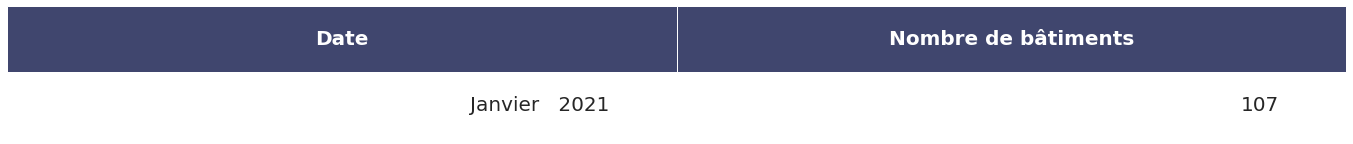

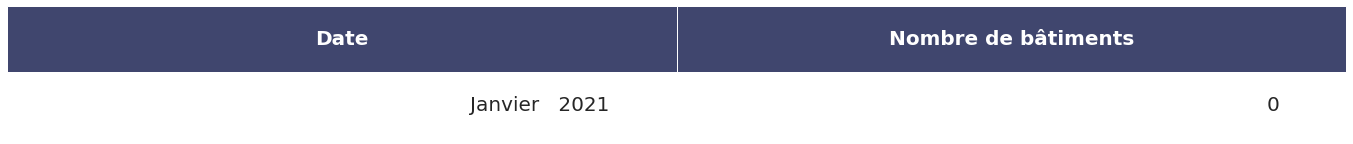

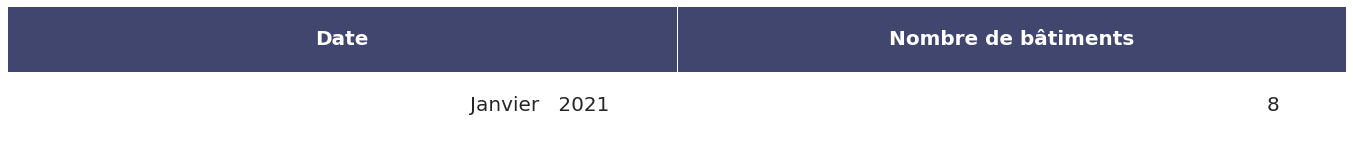

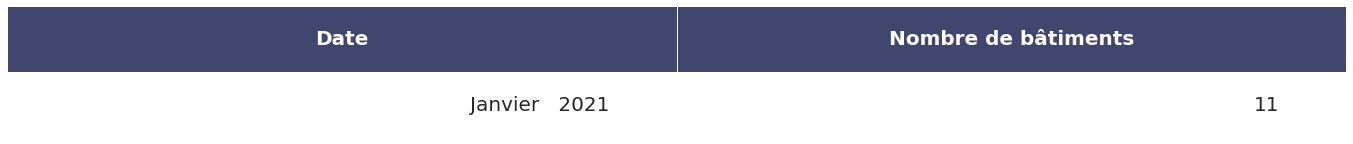

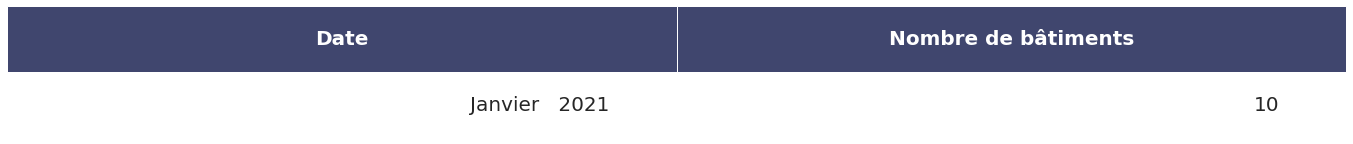

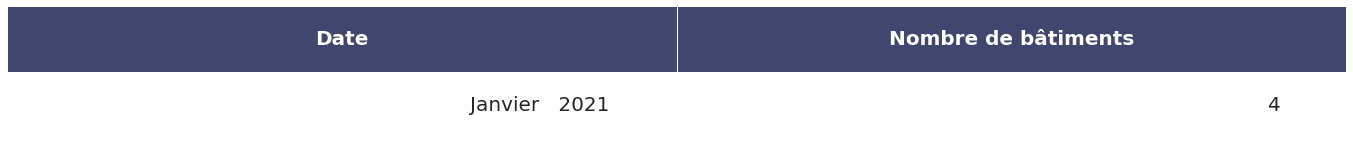

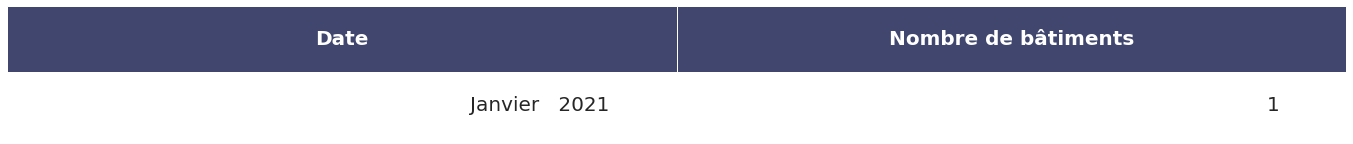

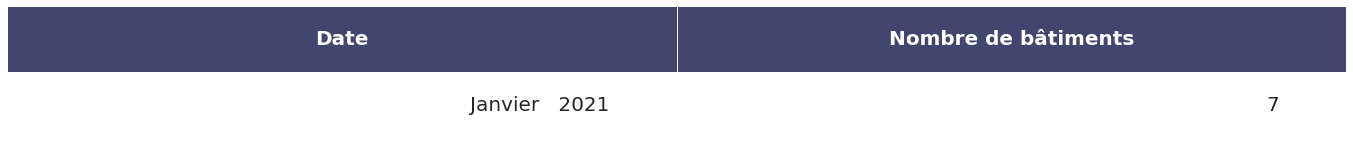

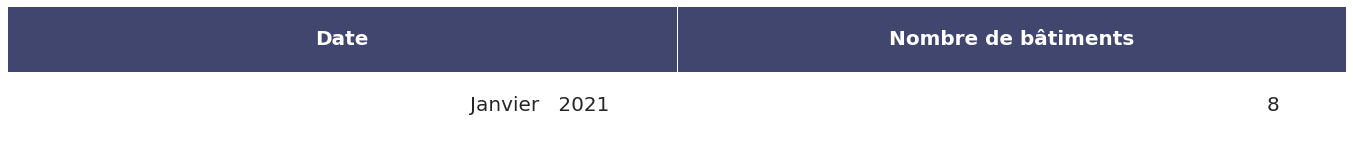

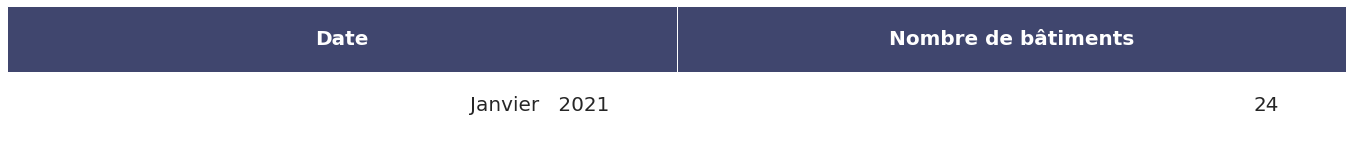

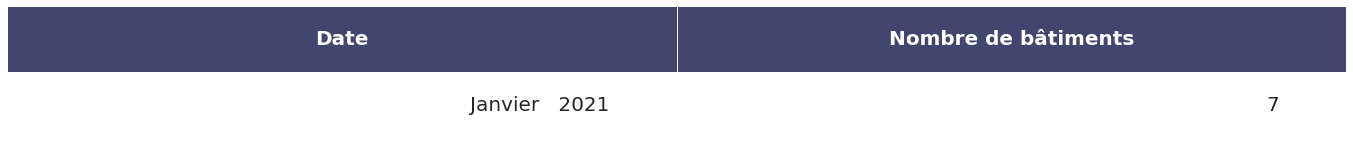

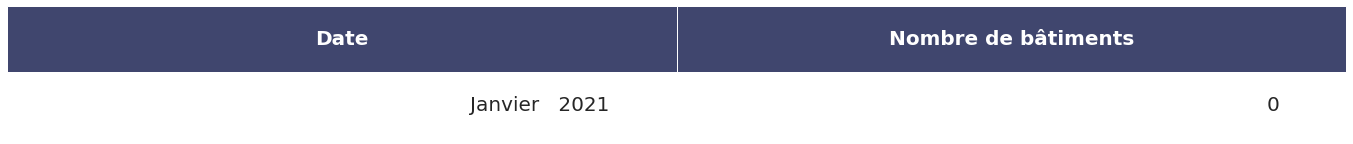

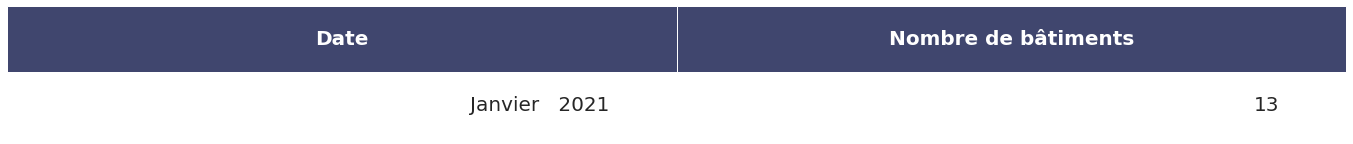

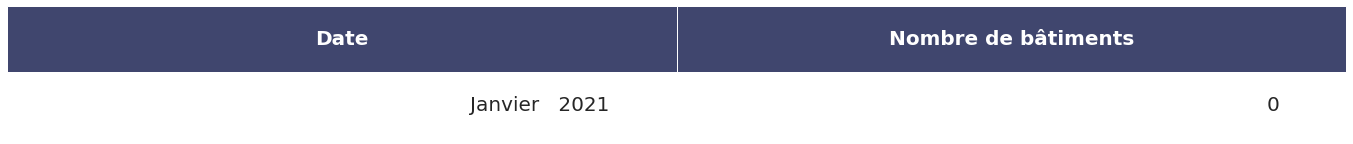

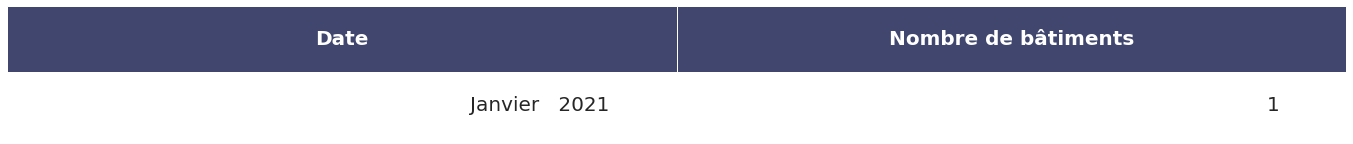

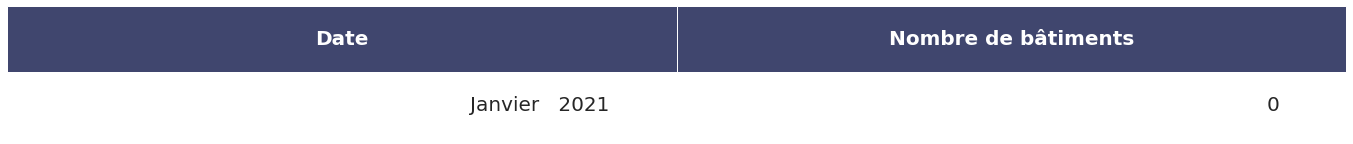

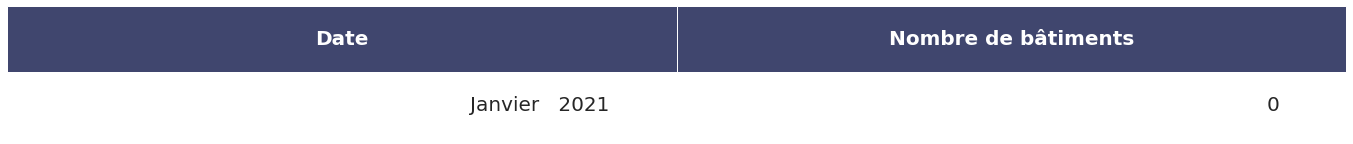

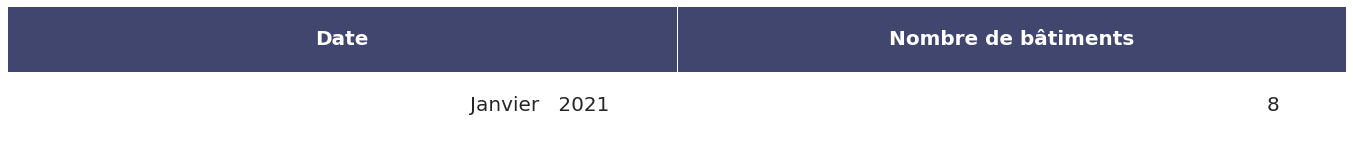

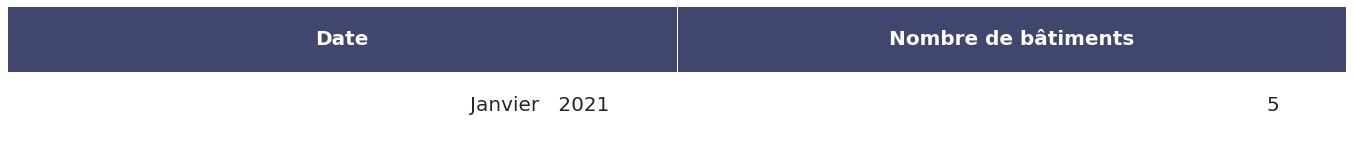

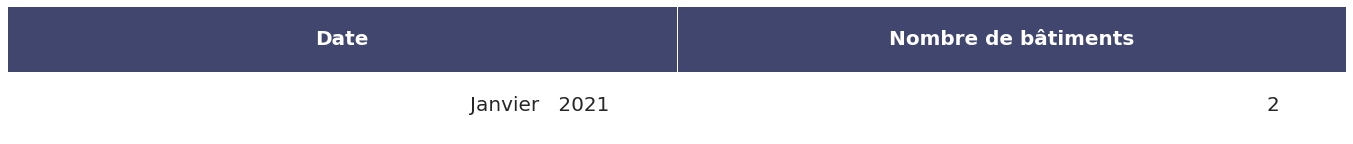

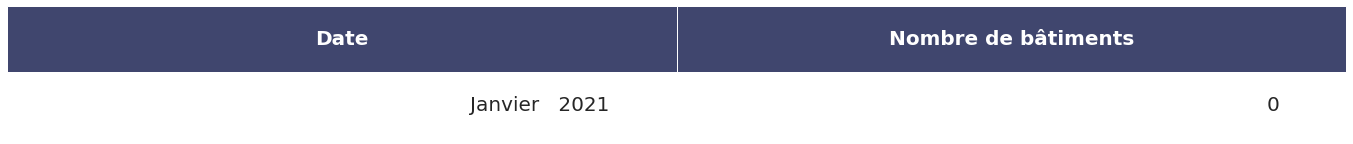

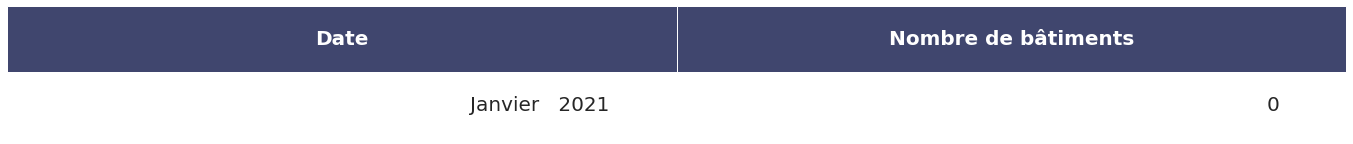

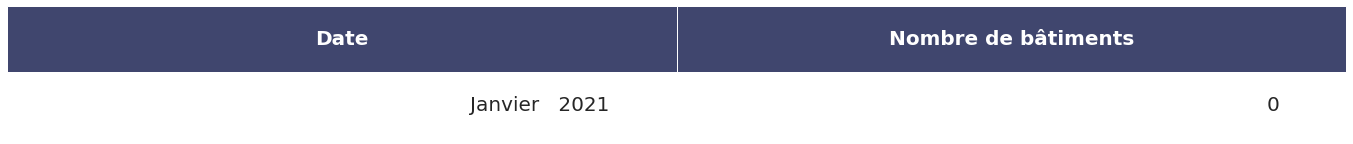

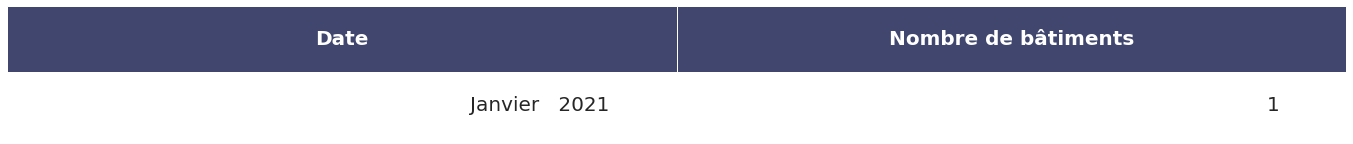

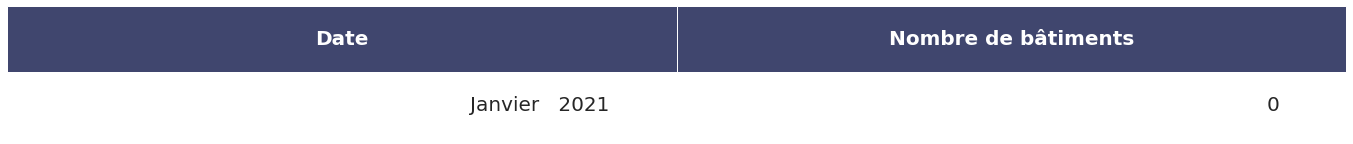

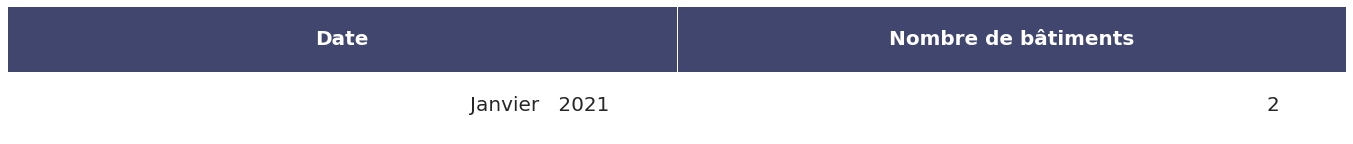

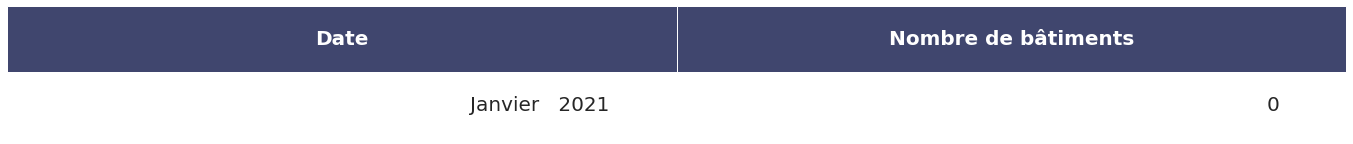

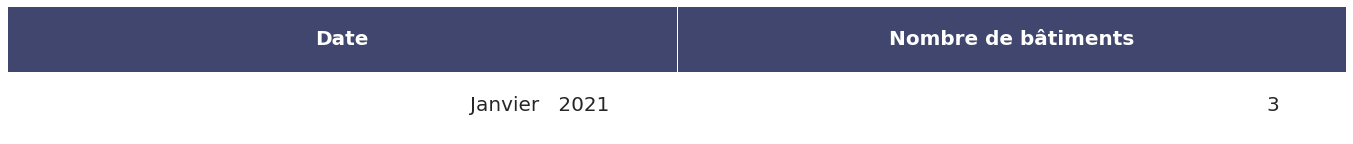

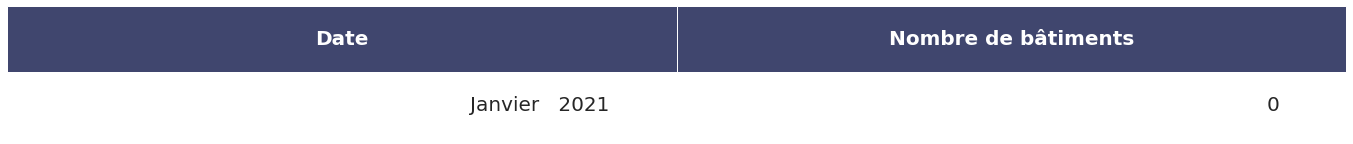

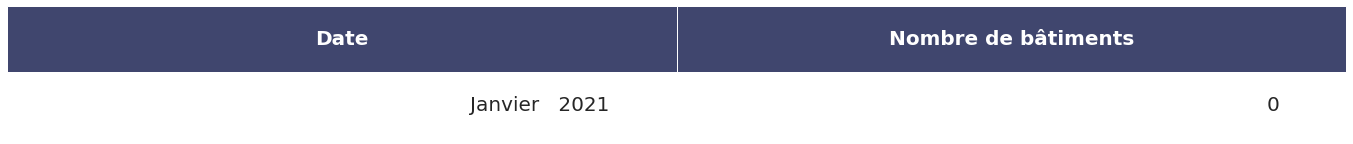

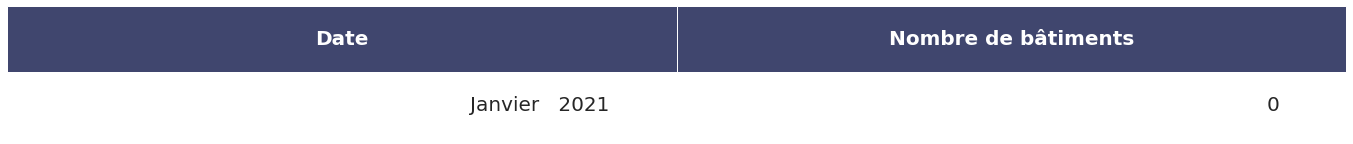

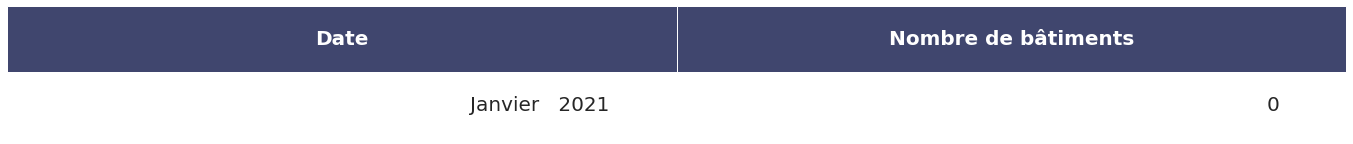

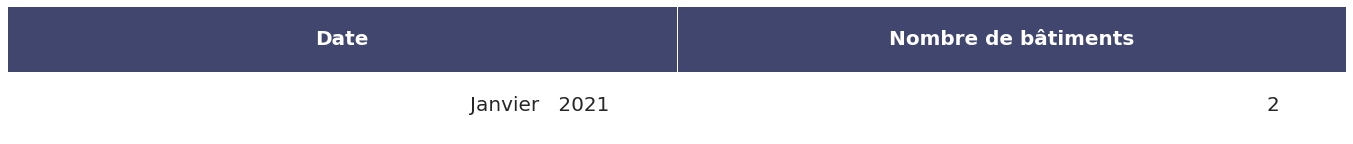

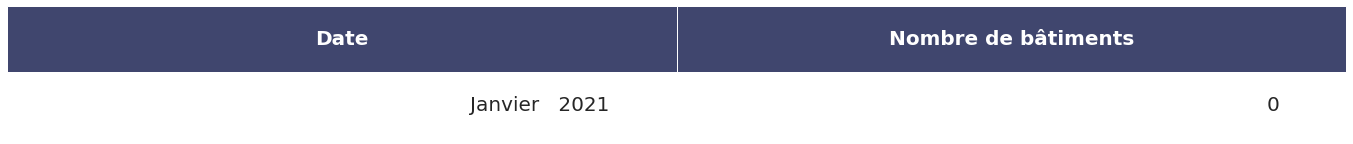

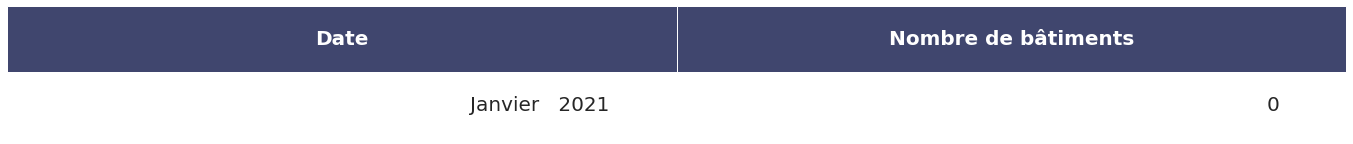

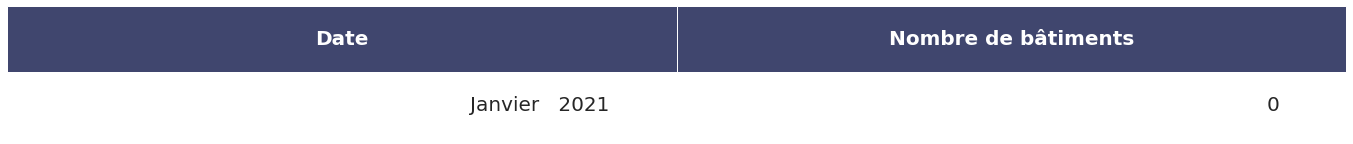

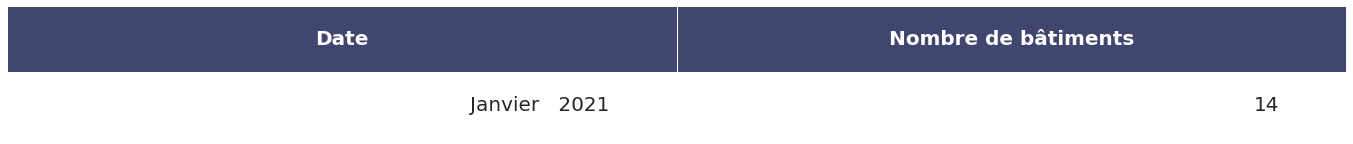

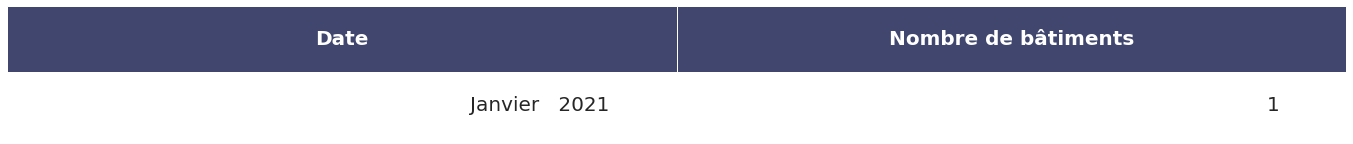

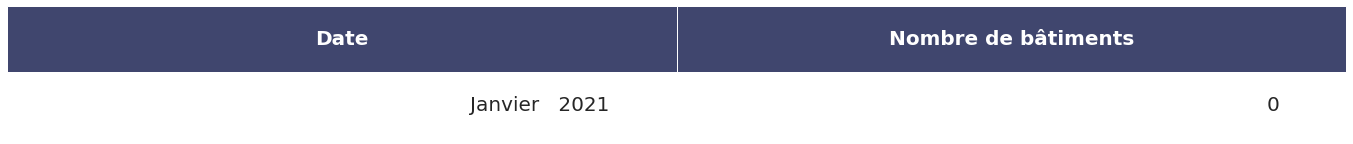

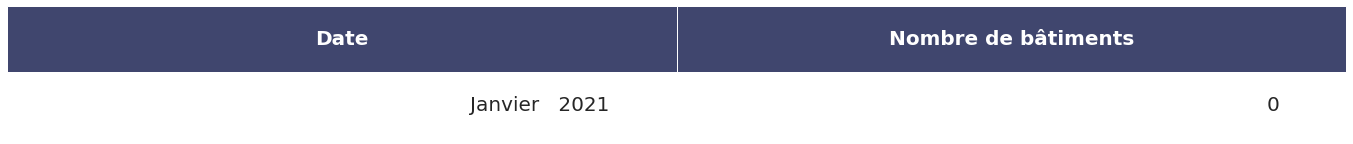

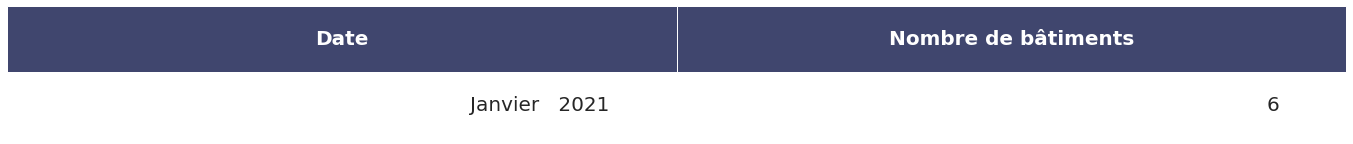

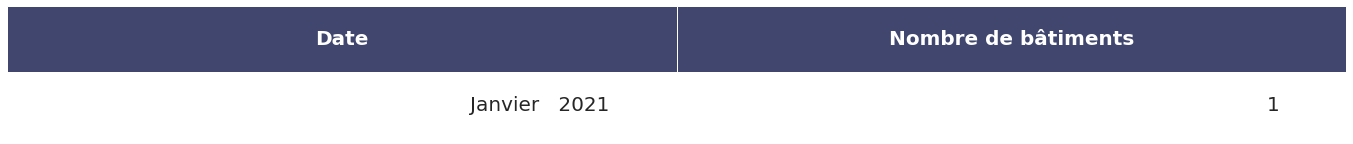

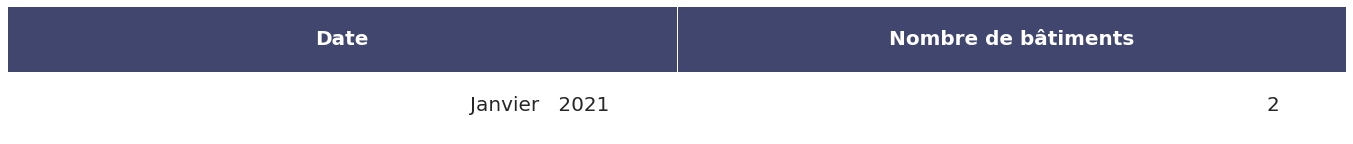

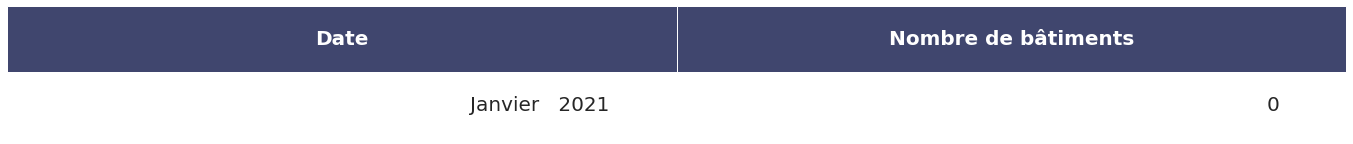

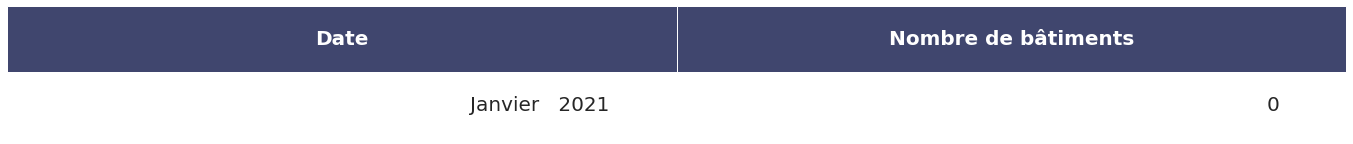

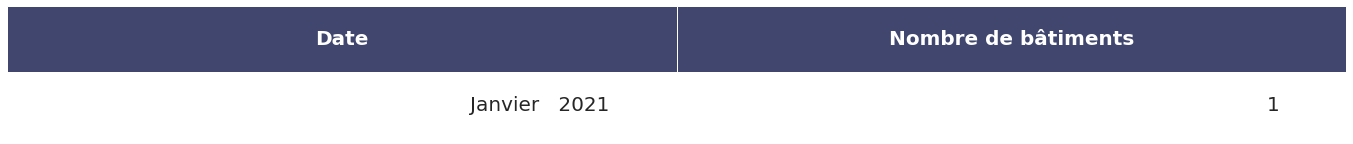

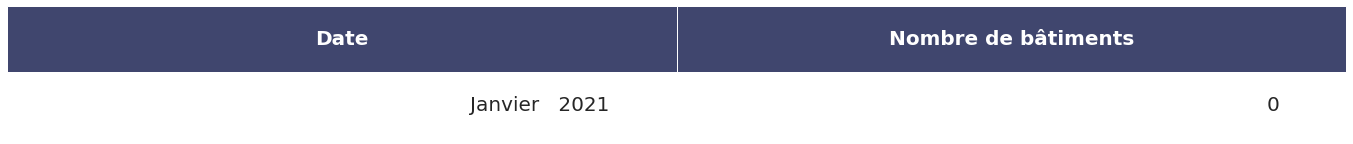

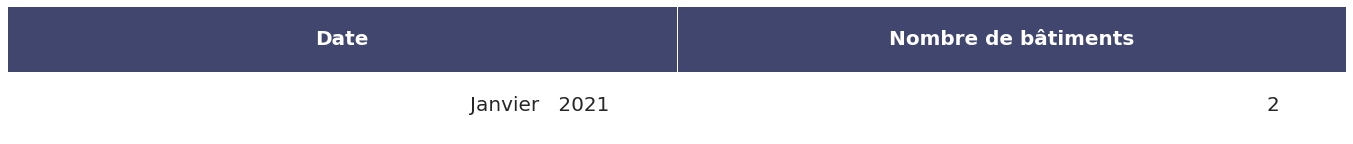

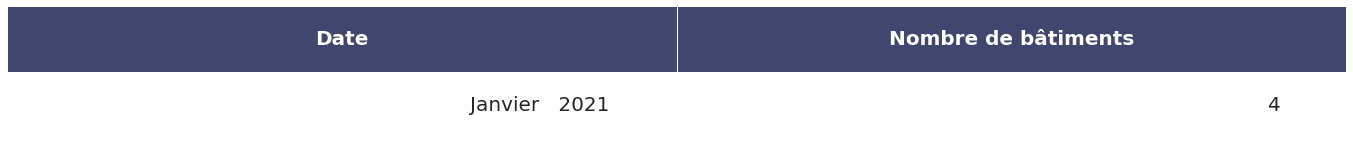

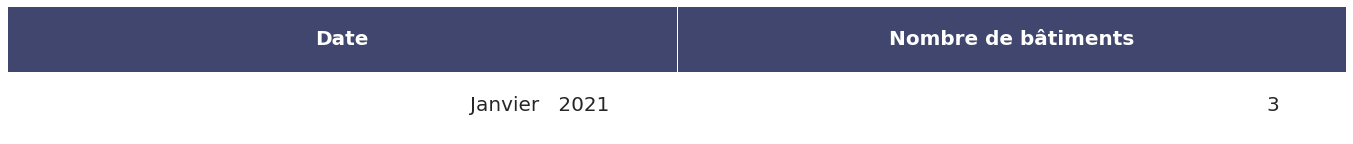

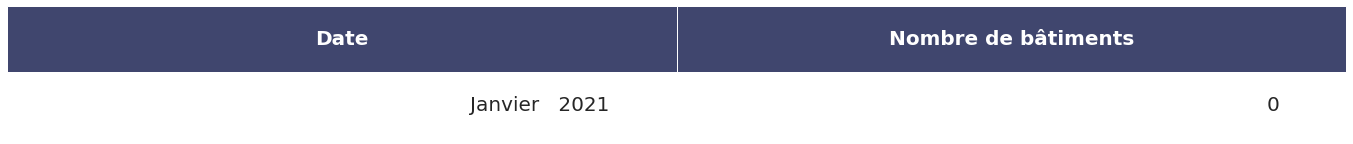

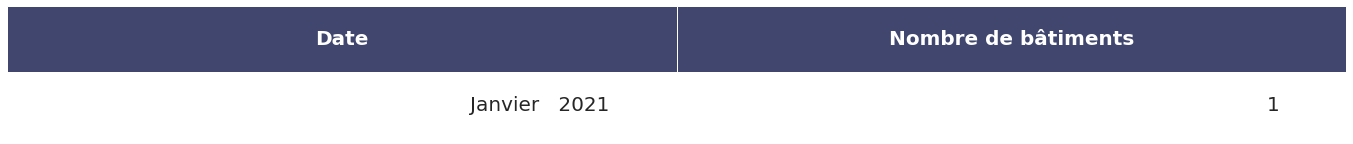

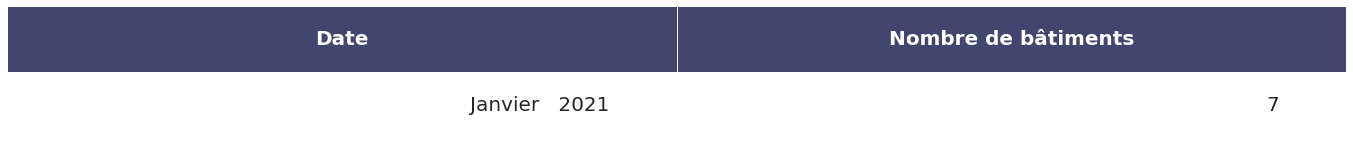

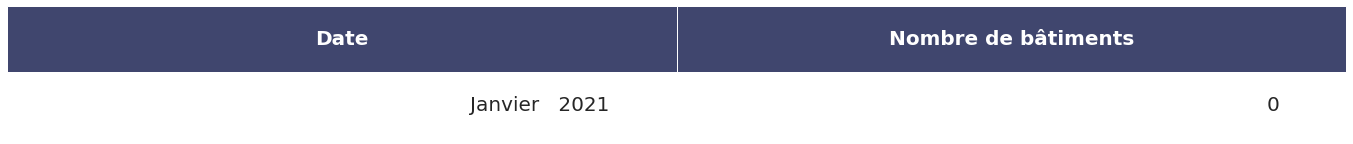

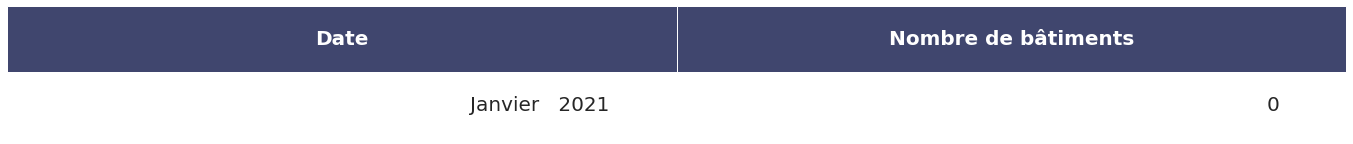

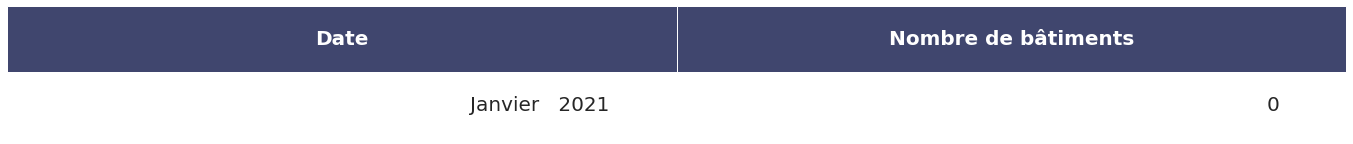

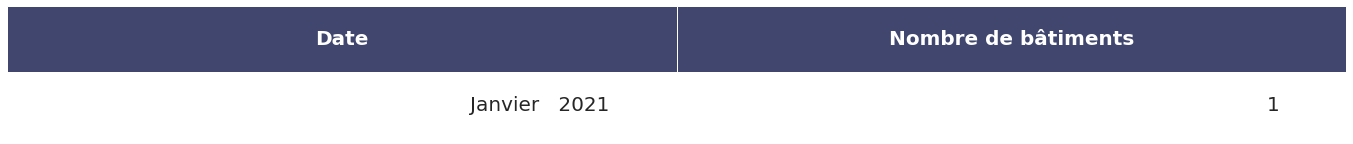

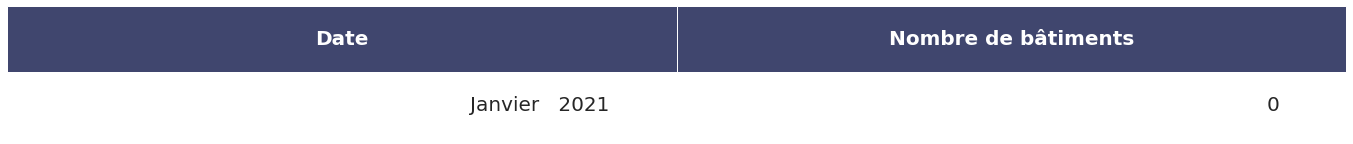

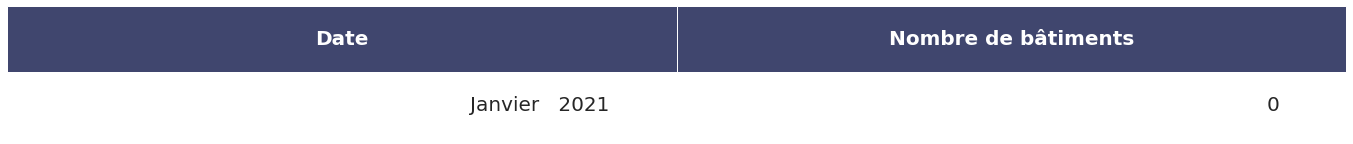

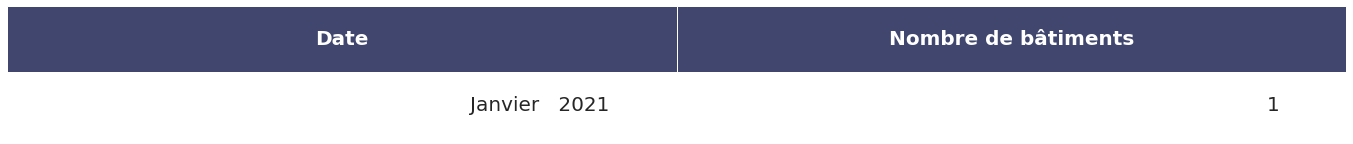

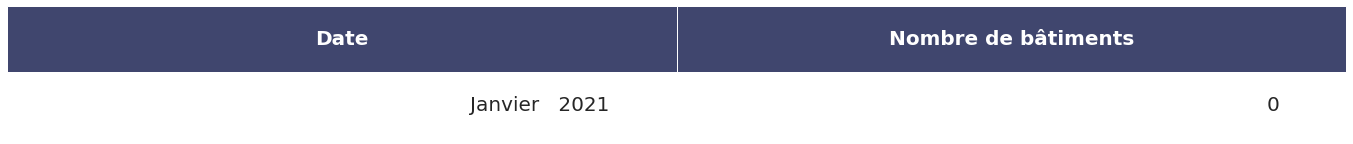

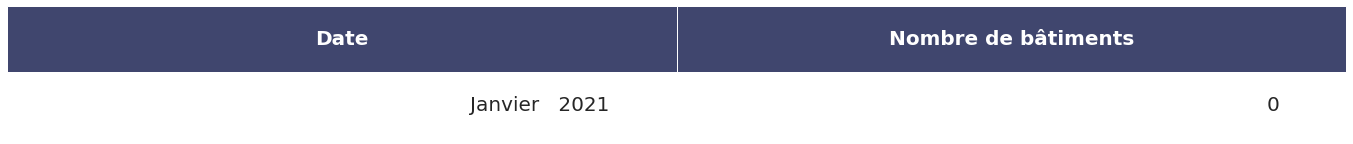

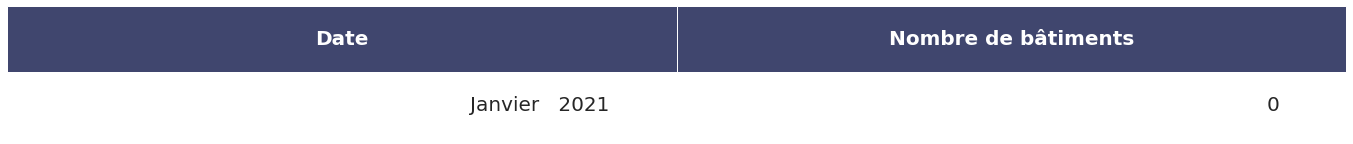

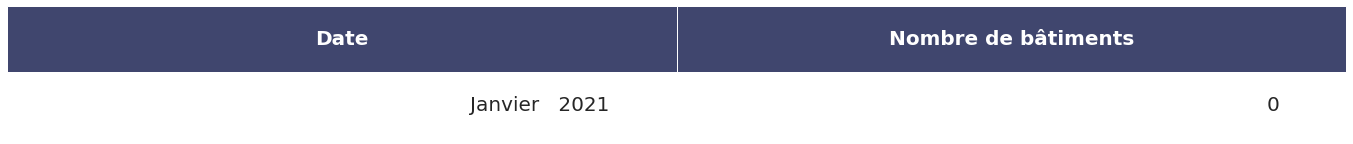

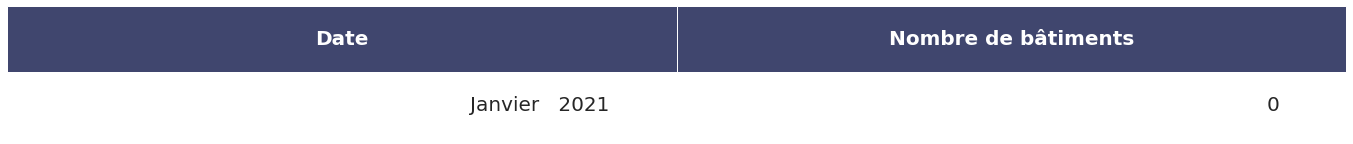

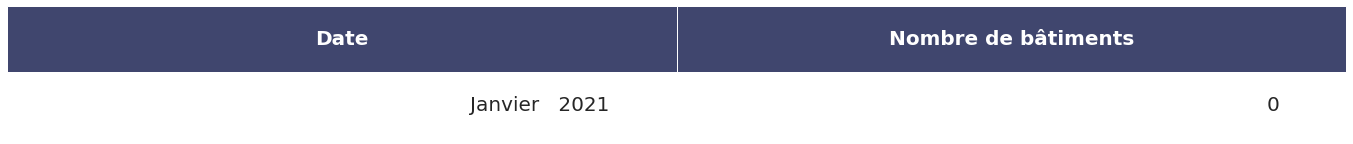

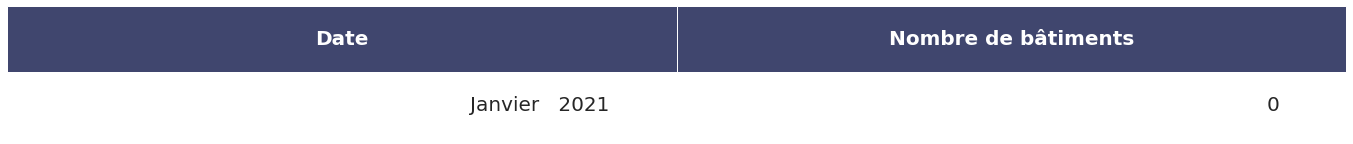

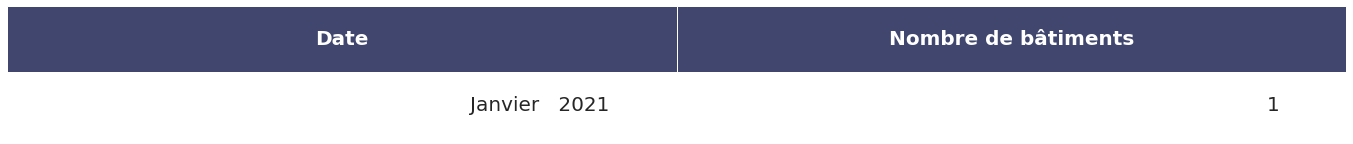

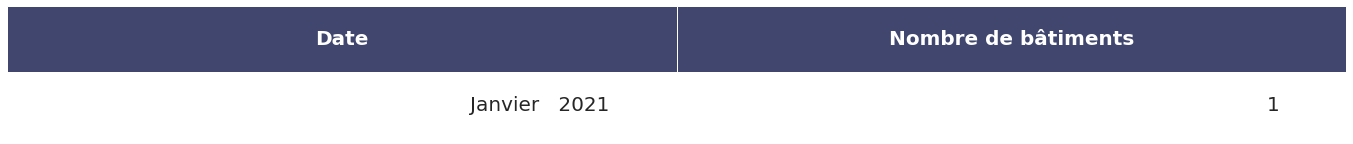

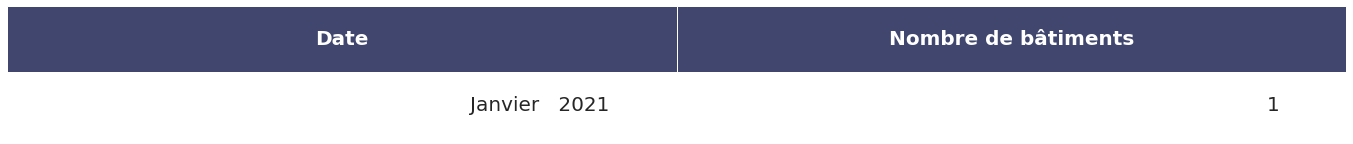

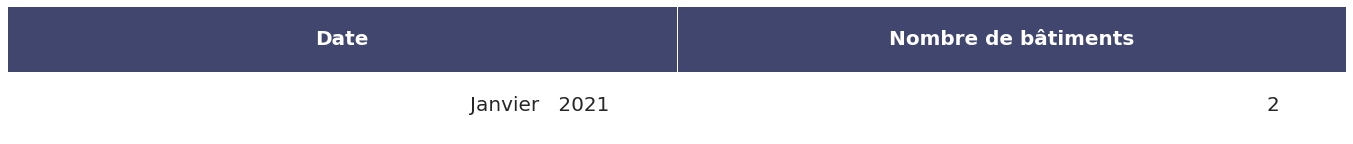

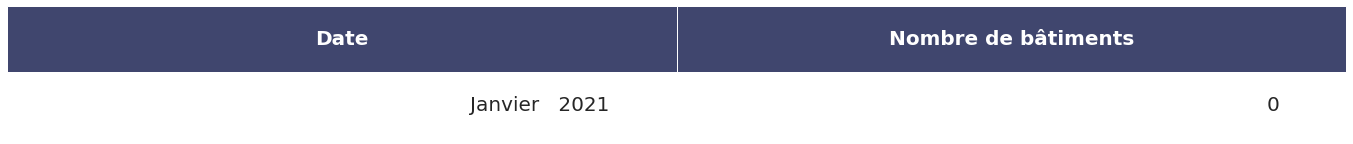

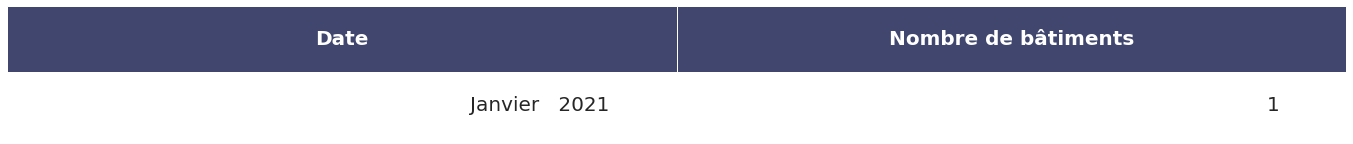

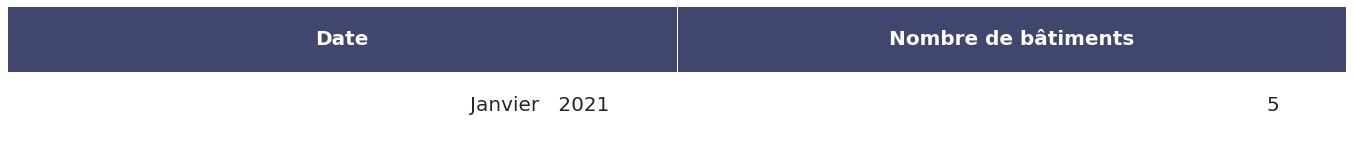

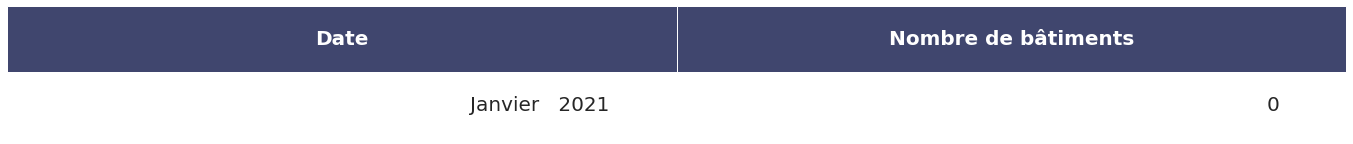

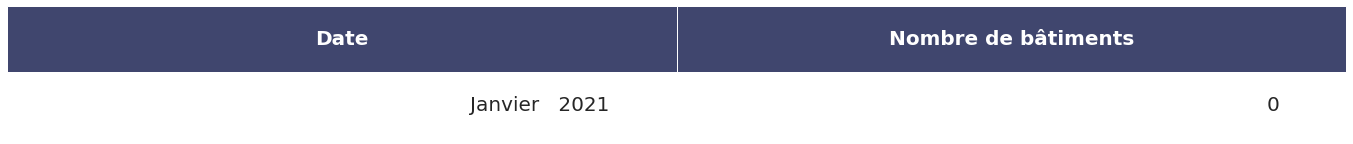

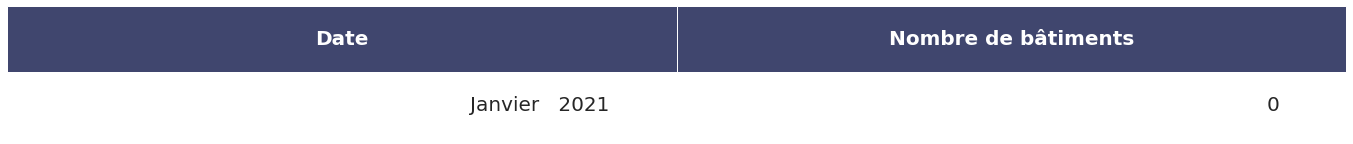

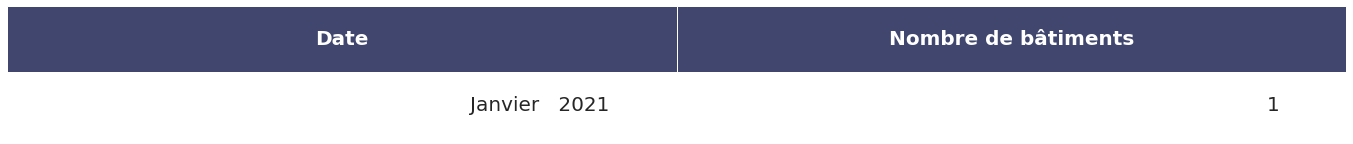

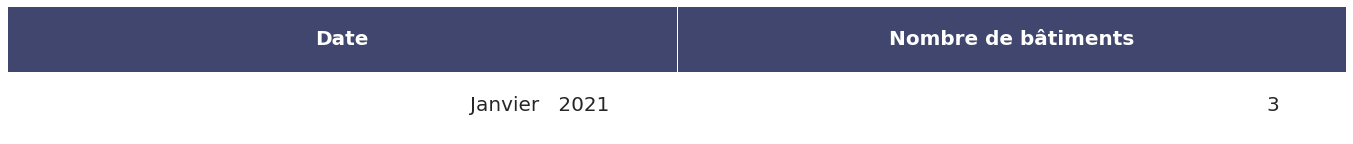

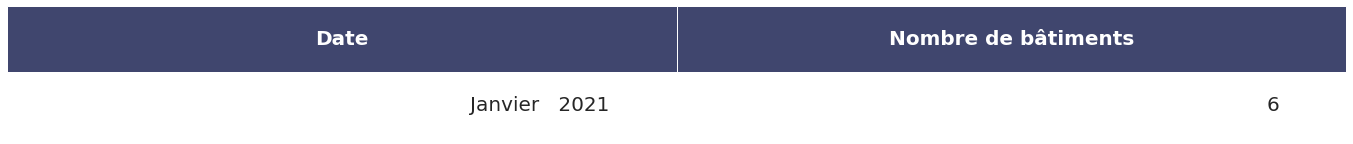

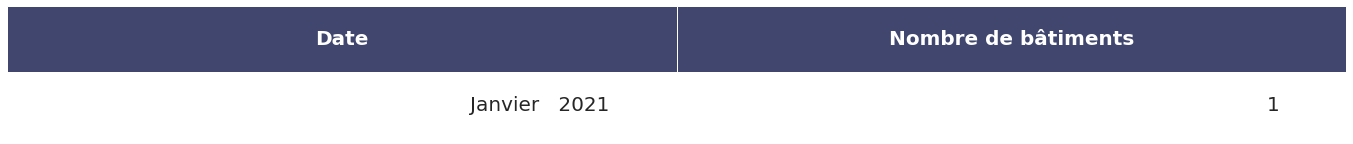

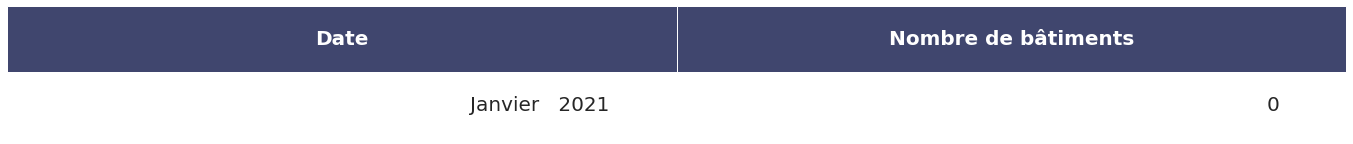

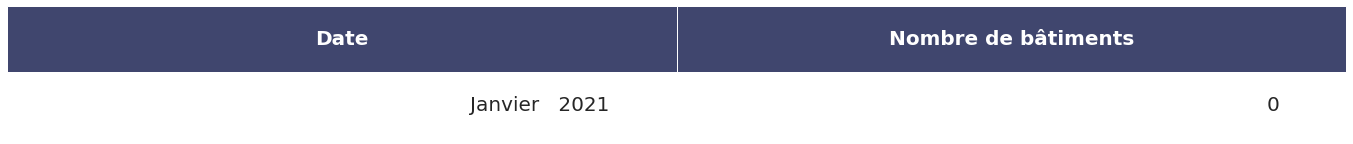

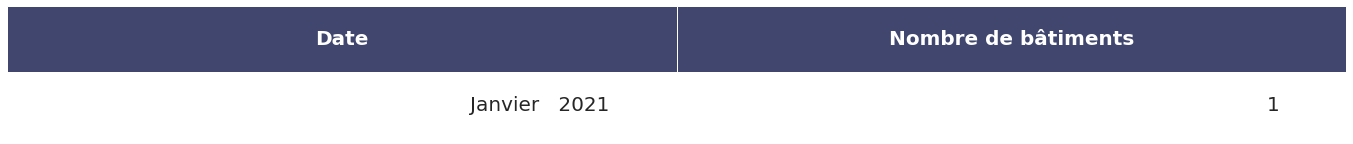

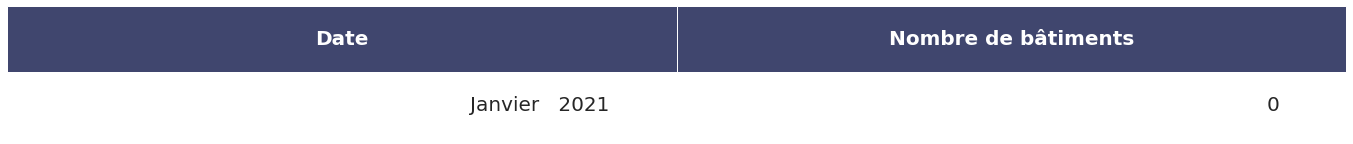

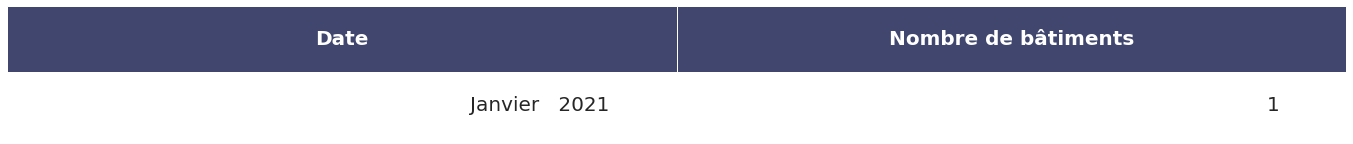

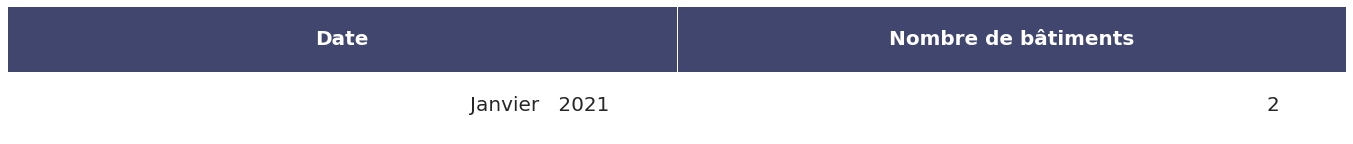

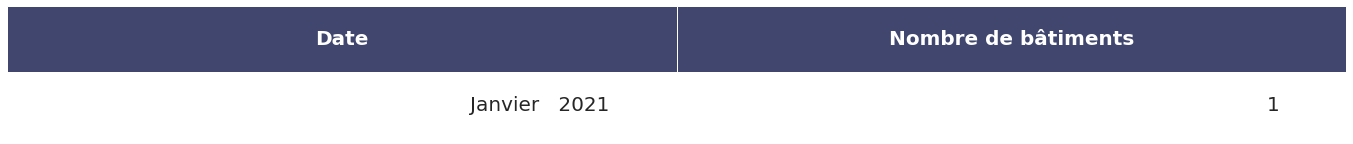

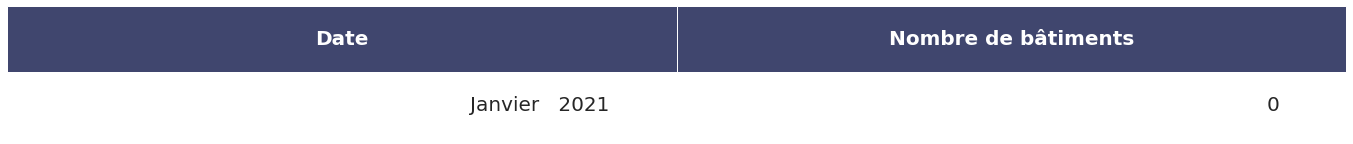

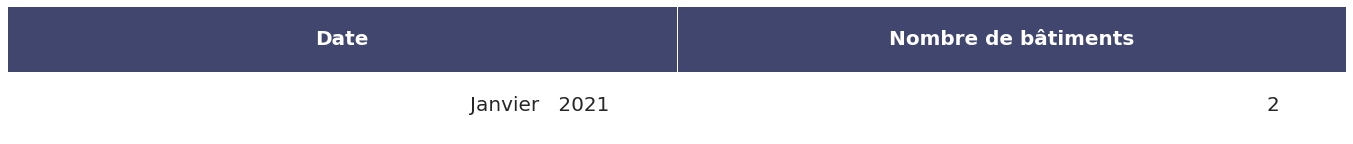

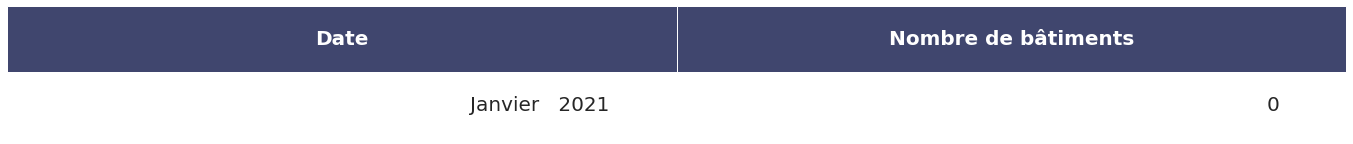

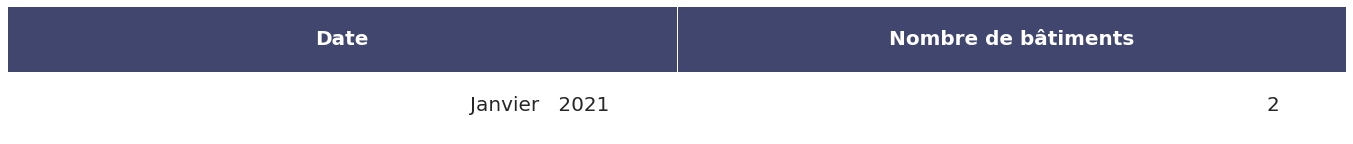

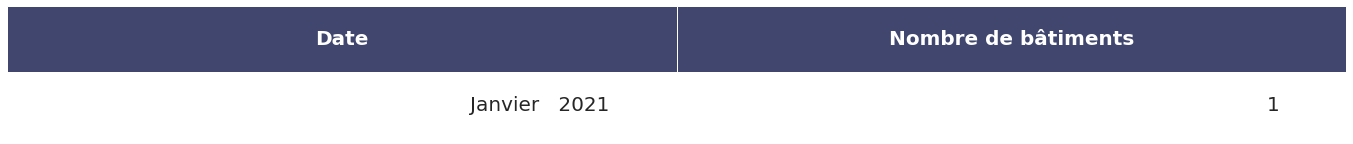

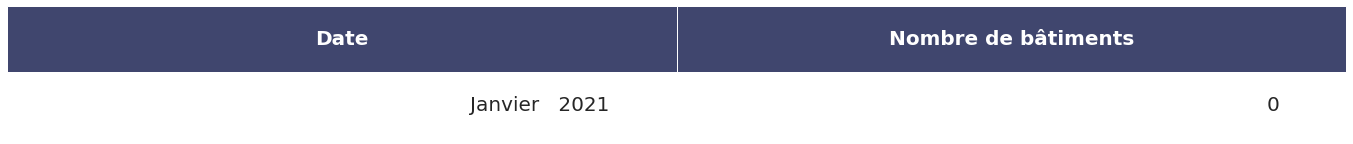

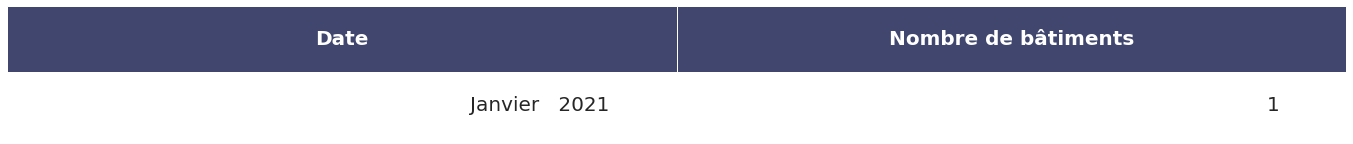

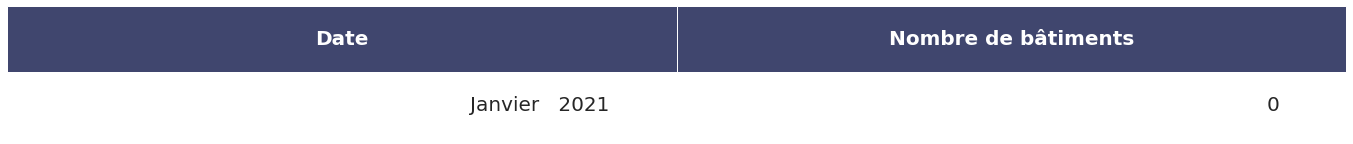

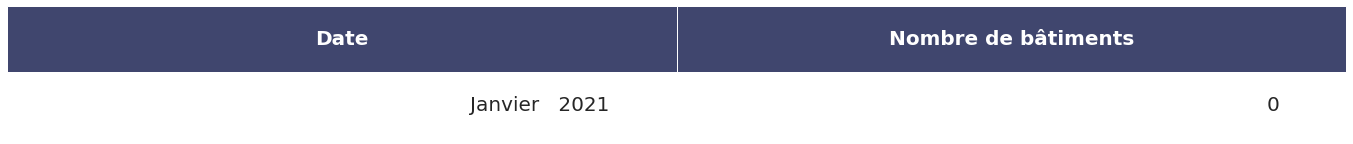

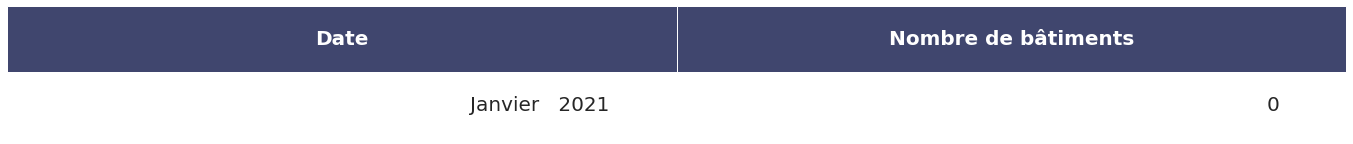

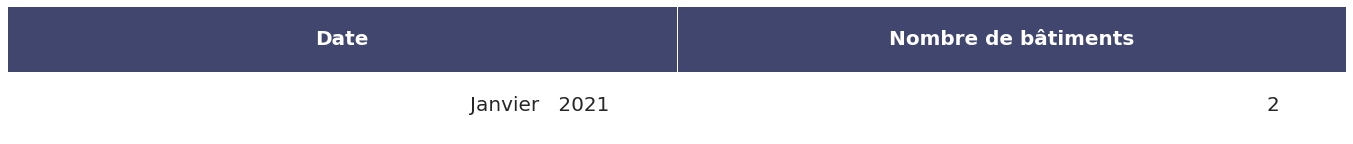

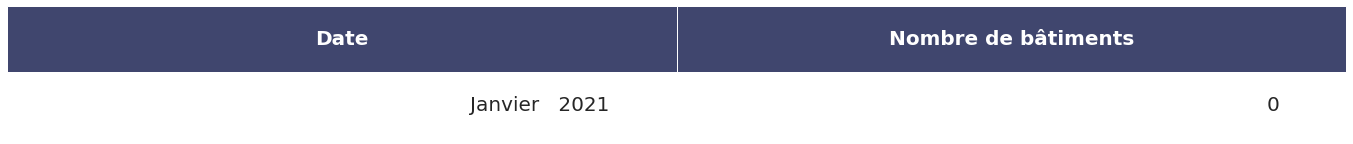

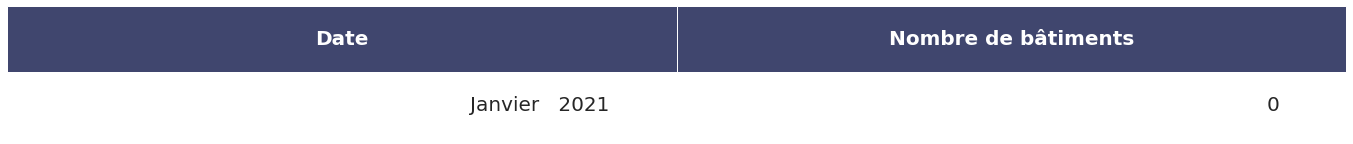

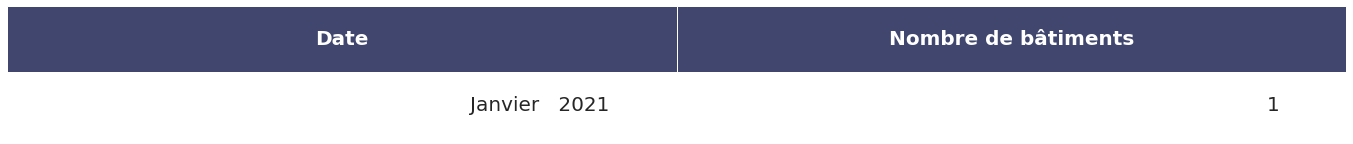

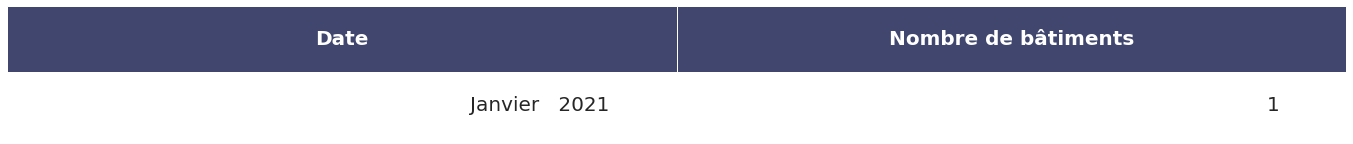

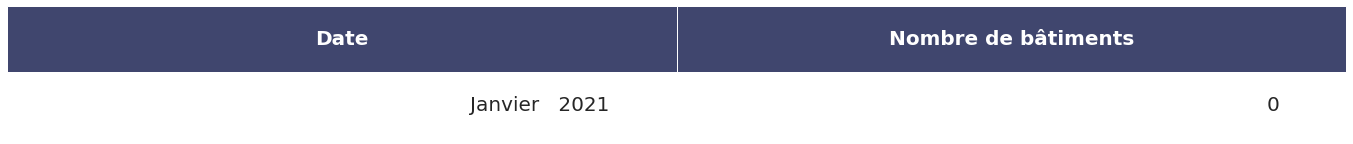

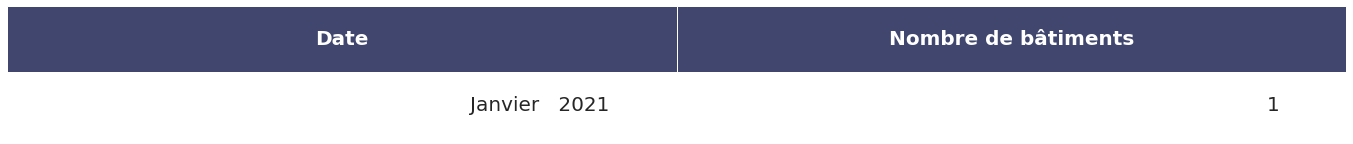

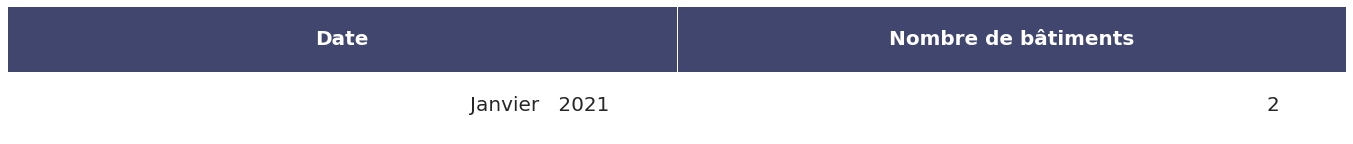

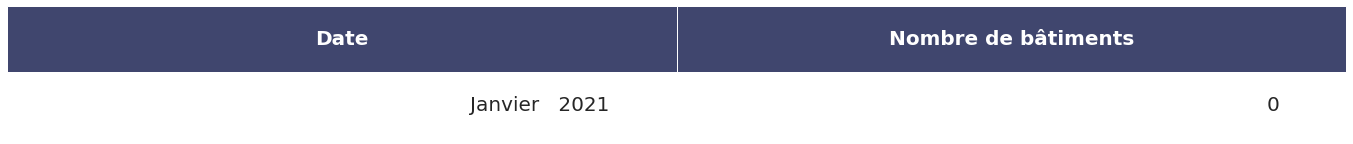

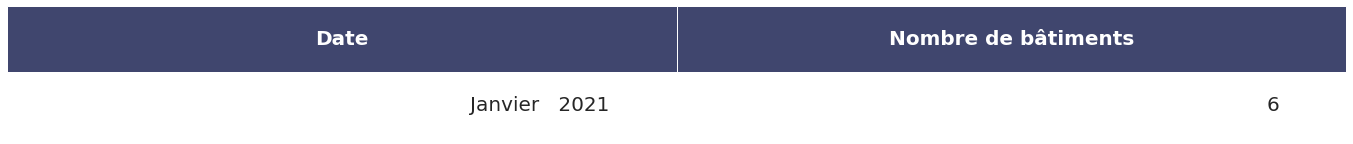

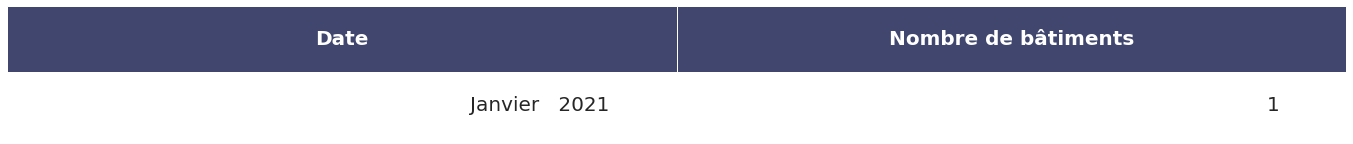

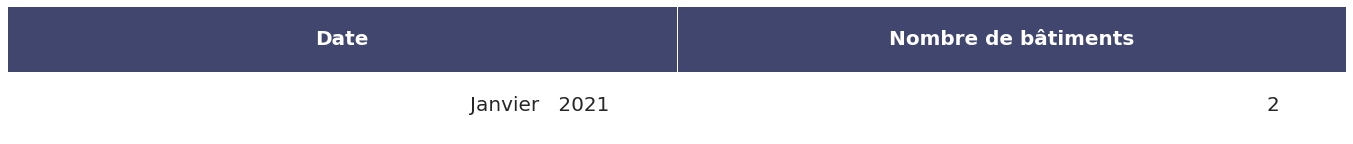

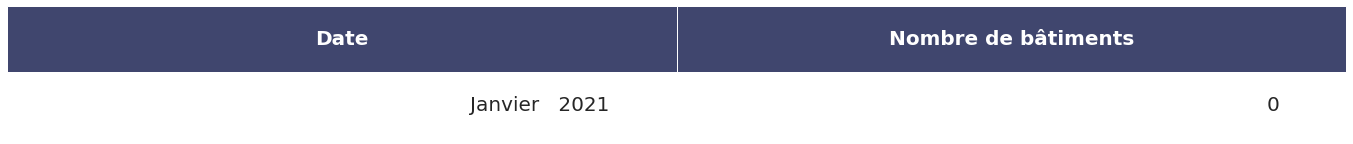

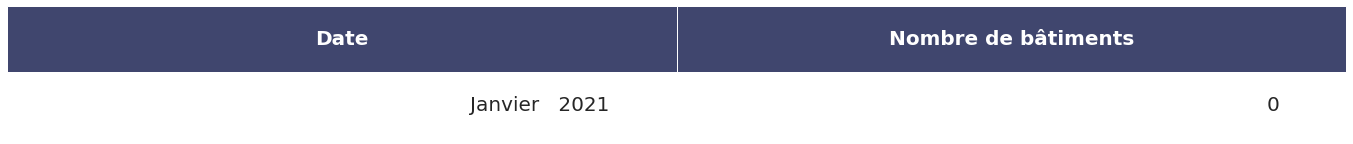

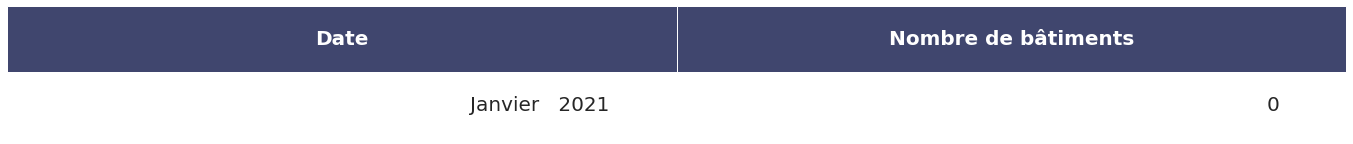

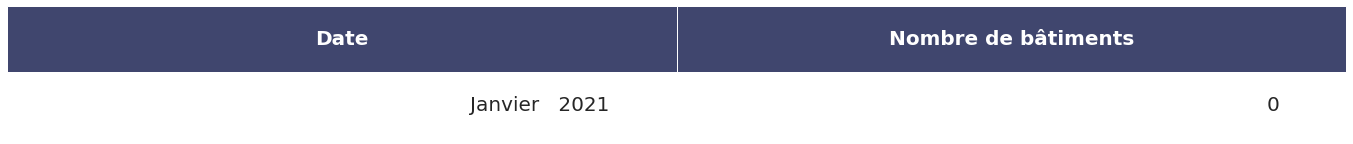

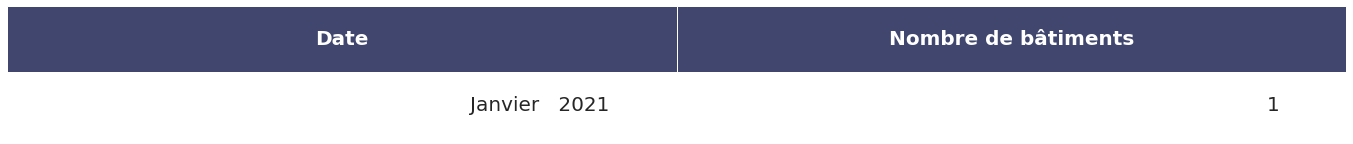

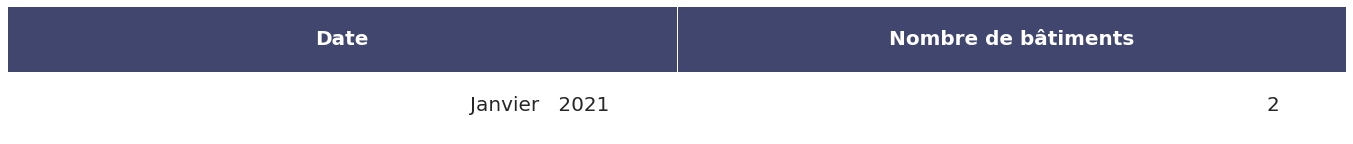

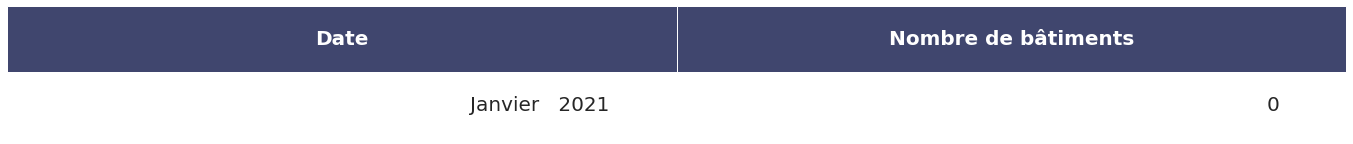

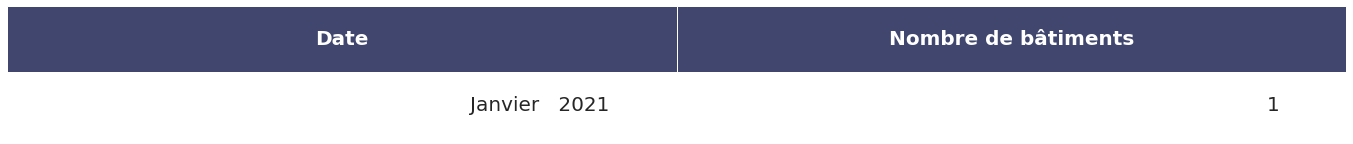

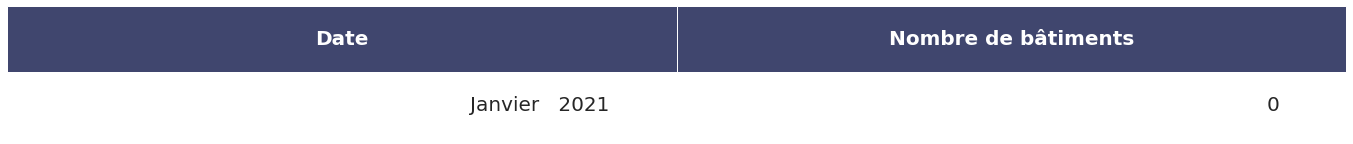

In [54]:
#mesure_filter = "Ma Prime Rénov'"
#make_all_charts(mesure_filter)
#make_all_charts()
mesure_filter = 'Rénovation des bâtiments Etats (marchés notifiés)'
maille = "national"
for mesure,short_indic in list_mesure_indic:
    if mesure == mesure_filter:
        make_pp_chart(maille, mesure, short_indic)
maille = "regional"
for mesure, short_indic in list_mesure_indic:   
    if mesure == mesure_filter:
        make_pp_chart(maille, mesure, short_indic)
maille = "departemental"
for mesure, short_indic in list_mesure_indic:
    if mesure == mesure_filter:
        make_pp_chart(maille, mesure, short_indic)


In [55]:
#Building the folders structures
mkdir_ifnotexist(pp_img_dir_path)
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national'))

#Regions subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional'))
for reg in reg_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional', reg))
    
#Departements subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental'))
for dep in dep_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental', dep))

In [56]:
mkdir_ifnotexist(reports_dir_path)

In [57]:
global title_header
title_header = ''
global subtitle_header
subtitle_header = ''

In [58]:
class PDF(FPDF):
    def header(self):
        if (self.page_no() != 1 ):
            # Logo
            self.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
            self.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
            # Arial bold 15
            self.cell(40)
            self.add_font('Arial', 'B', 16, uni=True)
            self.set_font('Arial', 'B', 16)
            self.multi_cell(110, 10, title_header, 0, 1, 'A')

            # Move to the right
            # Title
            self.set_font('Arial', 'I', 9)
            self.cell(50)
            self.cell(50)
            #self.cell(50, 10, subtitle_header, 0, 1, 'A')#+' - aides-entreprises.data.gouv.fr', 0, 1, 'A', link='https://aides-entreprises.data.gouv.fr/')
            # Line break  
            pdf.line(40, 38, 170, 38)
            self.ln(7)
        
    # Page footer
    def footer(self):
        if (self.page_no() != 1 ):
            # Position at 1.5 cm from bottom
            self.set_y(-15)
            # Arial italic 8
            self.set_font('Arial', 'I', 8)
            # Page number
            
            #self.cell(0, 10, 'Direction Interministérielle du Numérique (DINUM) - Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')         

In [59]:
def format_val(val,add):
    return '{:,}'.format(int(float(val))).replace(',', ' ')+add

In [60]:
def get_propilot_kpis(mesure, maille, geo_libelle):
    if maille == "departemental":
        kpi = pp_dep.loc[(pp_dep.mesure == mesure) & (pp_dep.dep == geo_libelle)]
        if kpi.shape[0] > 0:
            count = kpi.iloc[0]["valeur"]
        else:
            count = 0
        return ("Inconnu", str(count))
    elif maille == "regional":
        kpi = pp_reg.loc[(pp_reg.mesure == mesure) & (pp_reg.reg == geo_libelle)]
        if kpi.shape[0] > 0:
            count = kpi.iloc[0]["valeur"]
        else:
            count = 0
        return ("Inconnu", str(count))
    elif maille == "national":
        kpi = pp_nat.loc[(pp_nat.mesure == mesure)]
        if kpi.shape[0] > 0:
            count = kpi.iloc[0]["valeur"]
        else:
            count = 0
        return ("Inconnu", str(count))
    else:
        return ("Inconnu", "Inconnu")   

In [61]:
def add_propilot_page_report(pdf, dep, short_mesure, phrase1, phrase2, phrase3, phrase_nombre, source_dict):
    
    pdf.set_fill_color(83,101,125);
    """
    pdf.rect(20,41,180,14,'F')
    
    pdf.image(os.path.join(img_dir_path, 'information.png'), x=10, y=44.5, w=7)
    
    pdf.set_font('Arial', 'I', 7)
    pdf.set_text_color(255,255,255)
    pdf.cell(10)
    pdf.cell(10, 3, phrase1, ln=1)
    pdf.ln(0)
    pdf.cell(10)    
    pdf.cell(10, 3, phrase2, ln=1)
    pdf.ln(0)
    pdf.cell(10)
    pdf.cell(10, 3, phrase3, ln=1)
    pdf.ln(0)
    pdf.cell(10)
    pdf.set_font('Arial', 'IU', 7)
    pdf.cell(10, 3, source_dict['name'], ln=1, link=source_dict['url'])
    pdf.ln(2)
    
    pdf.cell(20)
    """
    pdf.set_y(47.00125)
    
    
    
    short_indic = dict_mesure_indic[short_mesure][0]
    kpi_dep = (pp_dep.loc[(pp_dep.dep == dep) 
                          & (pp_dep.short_mesure == short_mesure) 
                          & (pp_dep.short_indic == short_indic)]
                .sort_values(by="period_date", ascending=False))
    if kpi_dep.shape[0] != 0:
        date= kpi_dep.iloc[0].Date
        valeur = kpi_dep.iloc[0].valeur
    else:
        date = pp_dep.Date.max()
        valeur = 0
    #print(date, short_indic, valeur)
    pdf.add_font('Arial', '', 'arial.ttf', uni=True)
    pdf.set_font('Arial', '', 12)
    pdf.cell(12, 10, f"À {date}, {short_indic} : {valeur} (données cumulées)")
    pdf.ln(10)
 
    pdf.set_text_color(0,0,0)


    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau National", ln=1)
    
    
    pdf.set_font('Arial', '', 14)

    hbar_w = 120
    dpie_w = 20

    pdf.image(os.path.join(pp_img_dir_path, 'national','France', f"{short_mesure}-{short_indic}.png"), x=0, y=74, w=hbar_w)

    pdf.ln(12)
    pdf.cell((pdf.w/3)*1.55)
 
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)


    pdf.ln(27)

    reg = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['reg']
    libelle_reg = taxo_reg_df[taxo_reg_df['reg'] == reg].iloc[0]['libelle']
    libelle_dep = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    
    pdf.set_font('Arial', 'BI', 14)
    #print(pdf.get_y())
    pdf.cell(65, 10, "Niveau Régional : "+libelle_reg, ln=1)
    

    pdf.set_font('Arial', '', 14)

    path_reg = os.path.join(pp_img_dir_path, 'regional',reg, f"{short_mesure}-{short_indic}.png")
    #print(pdf.get_y())
    if os.path.exists(path_reg):    
        pdf.image(path_reg, x=0, y=133, w=hbar_w)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)

    pdf.ln(25)

    pdf.set_font('Arial', 'BI', 14)
    #print(pdf.get_y())
    pdf.cell(65, 15, "Niveau Départemental : "+libelle_dep, ln=1)
        

    pdf.set_font('Arial', '', 14)


    path_dep = os.path.join(pp_img_dir_path, 'departemental', dep, f"{short_mesure}-{short_indic}.png")
    if os.path.exists(path_dep):
        pdf.image(path_dep, x=0, y=210, w=hbar_w)
    libelle_dep = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    pdf.ln(8)
    pdf.cell((pdf.w/3)*1.55)
    #pdf.cell(0, 10, "Montant total : "+kpis_dep[0], 0, 0)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    
    pdf.link(10,57,120,8, 'http://aides-entreprises.data.gouv.fr')
    
    return pdf

In [62]:
%%time

mkdir_ifnotexist(os.path.join(reports_dir_path, 'pdf'))

counter = 0
for dep in taxo_dep_df.dep.unique():
    if dep != "01":
        continue
    counter += 1
    
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()

    #Logos
    pdf.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
    pdf.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
    
    # Arial bold 15
    pdf.set_font('Arial', 'B', 28)
    # Move to the right
    pdf.cell(50)
    pdf.ln(70)
    
    # Title
    pdf.cell(10)
    pdf.cell(50, 10, 'SUIVI TERRITORIAL', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'DU PLAN DE RELANCE', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50)

    pdf.set_font('Arial', 'I', 20)
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'Données pour le département : '+taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle'], 0, 1, 'A')
    pdf.ln(110)

    pdf.set_font('Arial', 'I', 8)

    pdf.cell(10)
    #pdf.cell(50, 10, 'Données publiées sur le tableau de bord des aides aux entreprises consultable sur https://aides-entreprises.data.gouv.fr', 0, 1, 'A')
    
    # TEST PROPILOT
    for short_mesure in short_mesures_to_keep:
        phrase1 = f"Ceci est un test avec {short_mesure}."
        phrase2 = ""
        phrase3 = ""
        source_dict= {'name':'Les données utilisées proviennent de ProPilot', 'url':'https://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/tableaux-de-bord/le-marche-du-travail-pendant-le-covid-19/tableaux-de-bord-hebdomadaires'}

        title_header = short_mesure
        
        pdf.add_page()
        pdf = add_propilot_page_report(pdf, dep, short_mesure, phrase1, phrase2, phrase3, ' : ', source_dict)
    # pdf, dep, aideurl, phrase1, phrase2, phrase3, phrase_nombre, source_dict    

    pdf.output(os.path.join(reports_dir_path, 'pdf', 'Suivi_aides_entreprises_'+taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']+'.pdf'), 'F')
    
    print(str(datetime.datetime.today()) + ' - ' + dep + ' done.')

2021-02-23 16:38:45.836892 - 01 done.
CPU times: user 13.1 s, sys: 9.14 ms, total: 13.1 s
Wall time: 13.2 s
